In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='10kbp_raw'

In [4]:
base_folder='/grid/gillis/data_norepl/lohia'

In [6]:
with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [7]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [1000]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
cat_list_genes = marker_table.index.tolist()

In [9]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [10]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [11]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [571]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [150]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            df2_list.append(m_tmp[m_tmp['rank'] < number_of_genes])
            #df2_list.append(marker_list[ (marker_list['rank'] < 300) & (marker_list['rank'] > 150) ])
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [1213]:
import random
o_list = list(range(1,30))
all_marker_1 = set(random.sample(o_list, 5))

all_marker_2 = set(o_list) - set(all_marker_1)

all_marker_1 = list(all_marker_1)
all_marker_2 = list(all_marker_2)

In [3931]:
all_marker_1 = list(np.arange(0,100, 1, dtype='int'))

all_marker_2 = list(np.arange(1,100, 2, dtype='int'))

all_marker_3 = list(np.arange(3,50, 5, dtype='int'))

In [3128]:
m_list = list(range(5))

In [3129]:
all_marker_1_more = [[random.choice(m_list) for i in list(range(0,5))] for i in range(0,5)]

In [3952]:
all_marker_1_more = [[random.choice(all_marker_1) for i in list(range(0,100))] for i in range(0,8)]

In [3914]:
all_marker_2_more = [[random.choice(all_marker_2) for i in list(range(0,50))] for i in range(0,4)]

In [3915]:
all_marker_1_more.extend(all_marker_2_more)

In [3568]:
m_list = list(range(100))

random.shuffle(m_list)

all_marker_1_more = [x.tolist() for x in np.array_split(m_list, 4)]

In [3835]:
all_marker_1_more = list(range(100))

In [3301]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3674]:
m_tmp.iloc[[0,10,0]]

group cell_type  rank    gene  recurrence     auroc  fold_change  \
88545  L6 IT   L6 IT_1     3  HPCAL1           8  0.843922     5.976110   
95134  L6 IT   L6 IT_2    26   WDR86           2  0.671255     2.782963   
88545  L6 IT   L6 IT_1     3  HPCAL1           8  0.843922     5.976110   

       fold_change_detection  expression  precision  ...  H200.1023_SSv4  \
88545               3.678201    13.81185   0.368624  ...            True   
95134               7.324902     3.01848   0.974913  ...            True   
88545               3.678201    13.81185   0.368624  ...            True   

       H18.30.002_10Xv3  H200.1023_10Xv3 H18.30.001_10Xv3 H19.30.001_10Xv3  \
88545              True             True             True            False   
95134             False            False            False            False   
88545              True             True             True            False   

      H19.30.001_NextGEM  H19.30.002_10Xv3 Ensembl_gene_identifier  Symbol  \
88545               True              True         ENSG00000115756  HPCAL1   
95134              False             False         ENSG00000187260   WDR86   
88545               True              True         ENSG00000115756  HPCAL1   

       adj_rank  
88545         0  
95134        10  
88545         0  

[3 rows x 25 columns]

In [3679]:
set(list(marker_iter)).intersection(m_tmp['adj_rank'].tolist())

{1, 5, 7, 9, 11, 13, 15, 19, 21, 31, 33, 35}

In [3676]:
m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]

group cell_type  rank      gene  recurrence     auroc  fold_change  \
78130   L6 IT   L6 IT_2    10     EPHA5           4  0.890977     3.906128   
90188   L6 IT   L6 IT_1    21   SLCO2A1           3  0.678393     4.241410   
19398   L6 IT   L6 IT_2    23   SHROOM3           2  0.698660     3.424806   
103897  L6 IT   L6 IT_1    26  ANKRD18B           2  0.713838     3.441580   
121510  L6 IT   L6 IT_2    30       ABO           2  0.585067     2.314014   
48191   L6 IT   L6 IT_1    32     MDGA1           2  0.659519     2.634454   
51342   L6 IT   L6 IT_1    39     TIMP2           1  0.769477     3.238243   
107051  L6 IT   L6 IT_2    50     TRAF5           1  0.680521     2.286051   
79656   L6 IT   L6 IT_2    53     KCNA3           1  0.672504     1.993730   
134750  L6 IT   L6 IT_2    84    IL1RL2           1  0.579180     1.599284   
134754  L6 IT   L6 IT_2    89     EMBP1           1  0.566034     1.370492   
134756  L6 IT   L6 IT_2    98      CHDH           1  0.537535     1.282900   

        fold_change_detection  expression  precision  ...  H200.1023_SSv4  \
78130                1.302194   62.539562   0.891774  ...            True   
90188                4.024424    6.488979   0.388787  ...            True   
19398                2.116198    8.841082   0.929496  ...            True   
103897               3.527945    6.380491   0.370766  ...           False   
121510              10.547409    1.343445   0.954607  ...            True   
48191                2.699836    4.422481   0.301062  ...            True   
51342                1.974931   15.174231   0.239960  ...           False   
107051               2.582116    6.141377   0.938261  ...           False   
79656                1.963701    7.707090   0.922406  ...           False   
134750               1.881547    2.966101   0.915917  ...            True   
134754               1.607915    2.000504   0.904790  ...            True   
134756               1.561393    1.340040   0.899855  ...           False   

        H18.30.002_10Xv3  H200.1023_10Xv3 H18.30.001_10Xv3 H19.30.001_10Xv3  \
78130               True            False            False            False   
90188              False            False            False            False   
19398              False            False            False            False   
103897             False            False            False            False   
121510             False            False            False            False   
48191              False            False            False            False   
51342              False            False            False            False   
107051             False            False            False            False   
79656              False            False            False            False   
134750             False            False            False            False   
134754             False            False            False            False   
134756             False            False            False            False   

       H19.30.001_NextGEM  H19.30.002_10Xv3 Ensembl_gene_identifier    Symbol  \
78130                True             False         ENSG00000145242     EPHA5   
90188               False             False         ENSG00000174640   SLCO2A1   
19398               False             False         ENSG00000138771   SHROOM3   
103897              False             False         ENSG00000230453  ANKRD18B   
121510              False             False         ENSG00000175164       ABO   
48191               False             False         ENSG00000112139     MDGA1   
51342               False             False         ENSG00000035862     TIMP2   
107051              False             False         ENSG00000082512     TRAF5   
79656               False             False         ENSG00000177272     KCNA3   
134750              False             False         ENSG00000115598    IL1RL2   
134754              False             False         ENSG00000231752     

In [3953]:
marker_mean_list = []
#for marker_iter in [all_marker_1, all_marker_2]:
for marker_iter in all_marker_1_more:
#for marker_iter in [3]:
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [10]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list.sort_values(by='rank')
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['group'])['group'].tolist()
            df2_list = []



            for group2 in all_group_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['group']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
                #print (m_tmp[m_tmp['rank'] < 50].shape)


                m_tmp = m_tmp[m_tmp['rank'] < 100]
                print ((m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0])
                marker_iter_tmp = [x for x in list(marker_iter) if x<= m_tmp['adj_rank'].max() ]
                
                print (len(marker_iter_tmp))

                if (m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0] >= 0:
                    #all_marker_2 = np.random.choice(mylist, size=20).tolist()
                    #df2_list.append(m_tmp[m_tmp['rank'] < 5])
                    #print (m_tmp['adj_rank'].max())
                    #marker_iter.extend(list(range(0,1)))
                    #df2_list.append(m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))])
                    
                    df2_list.append(m_tmp.iloc[marker_iter_tmp ])
                    #m_tmp.iloc[[0,10,0]]
                    #df2_list.append(m_tmp[m_tmp['rank'] <= 100])
                    #df2_list.append(marker_list[ (marker_list['rank'] < 300) & (marker_list['rank'] > 150) ])
                    #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                    #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                    #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            #marker_list['adj_rank'] = [i for i in list(range(0,marker_list.shape[0]))]
            #marker_list=marker_list[marker_list['adj_rank'].isin(list(marker_iter))]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier', 'group'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1

    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])



    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    marker_mean_list.append(df_gene_tp_all_info_mean)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

18
25
68
100
68
100
68
100
68
100
65
97
68
100
26
40
68
100
68
100
48
75
68
100
68
100
59
90
31
47
68
100
36
54
53
80
54
83
58
88
59
90
39
58
56
85
25
39


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

17
28
59
100
59
100
59
100
59
100
56
94
59
100
23
39
59
100
59
100
42
68
59
100
59
100
50
84
24
40
59
100
30
47
46
77
47
79
49
82
50
84
34
53
49
82
23
39


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

19
34
62
100
62
100
62
100
62
100
60
98
62
100
27
49
62
100
62
100
44
72
62
100
62
100
52
86
29
51
62
100
32
56
49
81
50
83
52
86
52
86
35
60
51
85
27
49


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

16
27
67
100
67
100
67
100
67
100
64
96
67
100
26
38
67
100
67
100
47
70
67
100
67
100
57
86
32
45
67
100
36
52
52
77
52
77
56
84
57
86
40
57
54
79
25
37


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

16
30
59
100
59
100
59
100
59
100
57
96
59
100
21
37
59
100
59
100
39
66
59
100
59
100
48
78
26
46
59
100
30
53
44
72
45
74
48
78
48
78
32
57
47
77
21
37


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

21
29
69
100
69
100
69
100
69
100
66
96
69
100
25
36
69
100
69
100
47
70
69
100
69
100
60
85
31
45
69
100
35
52
52
75
52
75
58
83
60
85
38
56
57
80
25
36


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

17
24
67
100
67
100
67
100
67
100
66
99
67
100
26
45
67
100
67
100
49
77
67
100
67
100
60
91
30
50
67
100
34
57
53
83
53
83
59
90
60
91
38
63
57
87
25
44


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-3953-f1a91fb2082d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

15
26
61
100
61
100
61
100
61
100
58
95
61
100
21
34
61
100
61
100
40
68
61
100
61
100
51
83
24
39
61
100
31
48
45
73
46
74
50
81
51
83
31
48
48
77
20
32


In [ ]:
import random
marker_mean_list = []
#for marker_iter in [all_marker_1, all_marker_2]:
#for marker_iter in all_marker_1_more:
for marker_iter_st in list(range(0,1000)):
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [10]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:
            
            


            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            #marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] < 100]

            
            if marker_level == 'type':

                marker_list_t = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

                marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

                marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
                marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


                marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type', 'rank']].merge(marker_list_t[['classt', 'group']])
            
            #marker_list = marker_list.drop_duplicates(subset=['classt','Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['classt']=='GABAergic']
            
            #print (marker_list.sort_values(by='cell_type'))

            
            

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['group'])['group'].tolist()
            df2_list = []
            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


                df2_list.append(m_tmp)
                    

            marker_list=pd.concat(df2_list)
            
            #print (marker_l)
            #marker_list = marker_list.sort_values(by=['classt', 'rank'], ascending=False).drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list[marker_list['classt']=='Glutamatergic']
            marker_list = marker_list.sort_values(by=['rank'], ascending=True).drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank'], ascending=True).drop_duplicates(subset=['Ensembl_gene_identifier'])
            
            
            df2_list = []
            
            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
                #print (m_tmp[m_tmp['rank'] < 50].shape)


                #m_tmp = m_tmp[m_tmp['rank'] < 100]
                #print ((m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0])
                
                
                print (group2, m_tmp['adj_rank'].max())
                if m_tmp['adj_rank'].max() > 2:
                    all_marker_1 = list(np.arange(0,m_tmp['adj_rank'].max(), 1, dtype='int'))
                    #marker_iter = [random.choice(all_marker_1) for i in list(range(0,m_tmp['adj_rank'].max()))]
                    marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
                    #marker_iter_tmp = [x for x in list(marker_iter) if x<= m_tmp['adj_rank'].max() ]
                

                    df2_list.append(m_tmp[m_tmp['adj_rank'].isin(list(all_marker_1))])
                    
                    #df2_list.append(m_tmp.iloc[marker_iter])
                    #df2_list.append(m_tmp.iloc[marker_iter])


            marker_list=pd.concat(df2_list)
            #marker_list['adj_rank'] = [i for i in list(range(0,marker_list.shape[0]))]
            #marker_list=marker_list[marker_list['adj_rank'].isin(list(marker_iter))]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier', 'group'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])



    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()
    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    marker_mean_list.append(df_gene_tp_all_info_mean)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


 nan
VLMC_2 nan
VLMC_1 nan


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


 nan
Sst Chodl_2 nan
Sst Chodl_1 nan
VLMC_2 nan
VLMC_1 nan


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


 nan
Lamp5_Lhx6_2 nan
Pax6_1 nan
Pax6_4 nan
Pax6_2 nan
Pax6_3 nan
Micro-PVM_1 nan
Micro-PVM_2 nan
Micro-PVM_3 nan
OPC_2 nan
OPC_1 nan
Sst Chodl_2 nan
Sst Chodl_1 nan
VLMC_2 nan
VLMC_1 nan


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136


<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 nan
Pvalb_1 nan
Pvalb_12 nan
Pvalb_14 nan
Pvalb_16 nan
Pvalb_2 nan
Pvalb_15 nan
Pvalb_3 nan
Pvalb_10 nan
Pvalb_11 nan
Pvalb_13 nan
Pvalb_6 nan
Pvalb_7 nan
Pvalb_9 nan
Pvalb_5 nan
Pvalb_8 nan
Pvalb_4 nan
Sncg_4 nan
Sncg_5 nan
Sncg_9 nan
Sncg_6 nan
Sncg_7 nan
Sncg_2 nan
Sncg_3 nan
Sncg_1 nan
Sncg_8 nan
Sst_10 nan
Sst_11 nan
Sst_12 nan
Sst_18 nan
Sst_2 nan
Sst_21 nan
Sst_22 nan
Sst_23 nan
Sst_24 nan
Sst_3 nan
Sst_5 nan
Sst_27 nan
Sst_4 nan
Sst_6 nan
Sst_7 nan
Sst_8 nan
Sst_14 nan
Sst_15 nan
Sst_16 nan
Sst_17 nan
Sst_19 nan
Sst_20 nan
Sst_9 nan
Sst_1 nan
Sst_13 nan
Sst_25 nan
Sst_26 nan
Vip_14 nan
Vip_15 nan
Vip_16 nan
Vip_17 nan
Vip_18 nan
Vip_19 nan
Vip_20 nan
Vip_21 nan
Vip_22 nan
Vip_4 nan
Vip_10 nan
Vip_11 

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-176-83f2a4afbe43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Astro_1 nan
Astro_3 nan
Astro_4 nan
Astro_5 nan
Astro_2 nan
Chandelier_1 nan
Chandelier_2 nan
Endo_1 nan
Endo_2 nan
L2/3 IT_11 111
L2/3 IT_12 81
L2/3 IT_14 112
L2/3 IT_3 49
L2/3 IT_4 50
L2/3 IT_5 45
L2/3 IT_8 273
L2/3 IT_9 92
L2/3 IT_1 125
L2/3 IT_2 212
L2/3 IT_10 180
L2/3 IT_6 131
L2/3 IT_7 170
L2/3 IT_13 143
L4 IT_1 73
L4 IT_3 95
L4 IT_2 77
L5 ET_3 318
L5 ET_2 275
L5 ET_1 234
L5 IT_5 166
L5 IT_6 63
L5 IT_7 43
L5 IT_8 76
L5 IT_3 124
L5 IT_1 97
L5 IT_4 78
L5 IT_2 277
L5/6 NP_1 215
L5/6 NP_3 175
L5/6 NP_2 218
L5/6 NP_6 151
L5/6 NP_7 203
L5/6 NP_8 186
L5/6 NP_5 235
L5/6 NP_4 341
L6 CT_1 142
L6 CT_5 199
L6 CT_2 163
L6 CT_4 231
L6 CT_3 168
L6 IT_2 91
L6 IT_1 90
L6 IT Car3_1 200
L6 IT Car3_3 147
L6 IT Car3_2 136
L6 IT Car3_4 274
L6b_1 87
L6b_4 184
L6b_8 93
L6b_5 229
L6b_6 93
L6b_7 197
L6b_2 171
L6b_3 230
Lamp5_3 nan
Lamp5_4 nan
Lamp5_5 nan
Lamp5_6 nan
Lamp5_2 nan
Lamp5_1 nan
Oligo_1 nan
Oligo_2 nan
Oligo_6 nan
Oligo_5 nan
Oligo_10 nan
Oligo_8 nan
Oligo_7 nan
Oligo_3 nan
Oligo_4 nan
Oligo_9 

<ipython-input-176-83f2a4afbe43>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


In [183]:
import random
marker_mean_list = []
#for marker_iter in [all_marker_1, all_marker_2]:
#for marker_iter in all_marker_1_more:
for marker_iter_st in list(range(0,1)):
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [10]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:
            
            


            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            #marker_list = marker_list.sort_values(by='rank')
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] < 100]

            
            if marker_level == 'type':

                marker_list_t = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

                marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

                marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
                marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


                marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type', 'rank']].merge(marker_list_t[['classt', 'group']])
            
            #marker_list = marker_list.drop_duplicates(subset=['classt','Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['classt']=='GABAergic']
            
            #print (marker_list.sort_values(by='cell_type'))
            
            if marker_level == 'subclass':
                marker_list.rename(columns = {'group':'classt'}, inplace = True)
                marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
                marker_list['cell_type'] = marker_list['group'].tolist()

            
            

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['group'])['group'].tolist()
            df2_list = []
            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


                df2_list.append(m_tmp)
                    

            marker_list=pd.concat(df2_list)
            
            #print (marker_l)
            #marker_list = marker_list.sort_values(by=['classt', 'rank'], ascending=False).drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['classt']=='Glutamatergic']
            #marker_list = marker_list.sort_values(by=['rank'], ascending=True).drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank'], ascending=True).drop_duplicates(subset=['Ensembl_gene_identifier'])
            
            
            df2_list = []
            
            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
                #print (m_tmp[m_tmp['rank'] < 50].shape)


                #m_tmp = m_tmp[m_tmp['rank'] < 100]
                #print ((m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0])
                
                
                print (group2, m_tmp['adj_rank'].max())
                if m_tmp['adj_rank'].max() > 2:
                    all_marker_1 = list(np.arange(0,m_tmp['adj_rank'].max(), 1, dtype='int'))
                    #marker_iter = [random.choice(all_marker_1) for i in list(range(0,m_tmp['adj_rank'].max()))]
                    marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
                    #marker_iter_tmp = [x for x in list(marker_iter) if x<= m_tmp['adj_rank'].max() ]
                

                    df2_list.append(m_tmp[m_tmp['adj_rank'].isin(list(all_marker_1))])
                    
                    #df2_list.append(m_tmp.iloc[marker_iter])
                    #df2_list.append(m_tmp.iloc[marker_iter])


            marker_list=pd.concat(df2_list)
            #marker_list['adj_rank'] = [i for i in list(range(0,marker_list.shape[0]))]
            #marker_list=marker_list[marker_list['adj_rank'].isin(list(marker_iter))]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier', 'group'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])



    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()
    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    marker_mean_list.append(df_gene_tp_all_info_mean)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-183-12e4a57e8d42>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
<ipython-input-183-12e4a57e8d42>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Chandelier_1 87
Chandelier_2 111
Sst Chodl_2 79
Sst Chodl_1 77
L2/3 IT_14 49
L2/3 IT_7 56
L2/3 IT_10 74
L2/3 IT_13 42
L2/3 IT_8 107
L2/3 IT_11 32
L2/3 IT_6 45
L2/3 IT_4 16
L2/3 IT_5 17
L2/3 IT_12 30
L2/3 IT_2 59
L2/3 IT_1 32
L2/3 IT_3 19
L2/3 IT_9 30
Sncg_6 31
Sncg_9 48
Sncg_5 53
Sncg_1 53
Sncg_4 54
Sncg_3 57
Sncg_7 79
Sncg_2 61
Sncg_8 113
L5/6 NP_3 54
L5/6 NP_7 82
L5/6 NP_5 84
L5/6 NP_1 79
L5/6 NP_8 55
L5/6 NP_6 46
L5/6 NP_4 145
L5/6 NP_2 65
Pvalb_6 74
Pvalb_4 57
Pvalb_1 41
Pvalb_2 36
Pvalb_12 86
Pvalb_14 35
Pvalb_8 51
Pvalb_5 59
Pvalb_15 142
Pvalb_11 31
Pvalb_3 116
Pvalb_16 73
Pvalb_13 60
Pvalb_10 39
Pvalb_9 35
Pvalb_7 24
L6b_1 19
L6b_5 79
L6b_7 61
L6b_3 82
L6b_4 61
L6b_2 53
L6b_8 33
L6b_6 25
L6 CT_1 32
L6 CT_5 63
L6 CT_4 72
L6 CT_3 59
L6 CT_2 62
Lamp5_4 40
Lamp5_5 40
Lamp5_6 46
Lamp5_1 101
Lamp5_2 30
Lamp5_3 58
Oligo_1 198
Oligo_3 156
Oligo_9 169
Oligo_4 231
Oligo_10 200
Oligo_5 171
Oligo_7 265
Oligo_8 221
Oligo_6 188
Oligo_2 209
Sst_22 68
Sst_14 24
Sst_16 41
Sst_15 29
Sst_18 76
Sst

<ipython-input-188-04114a00ccd8>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


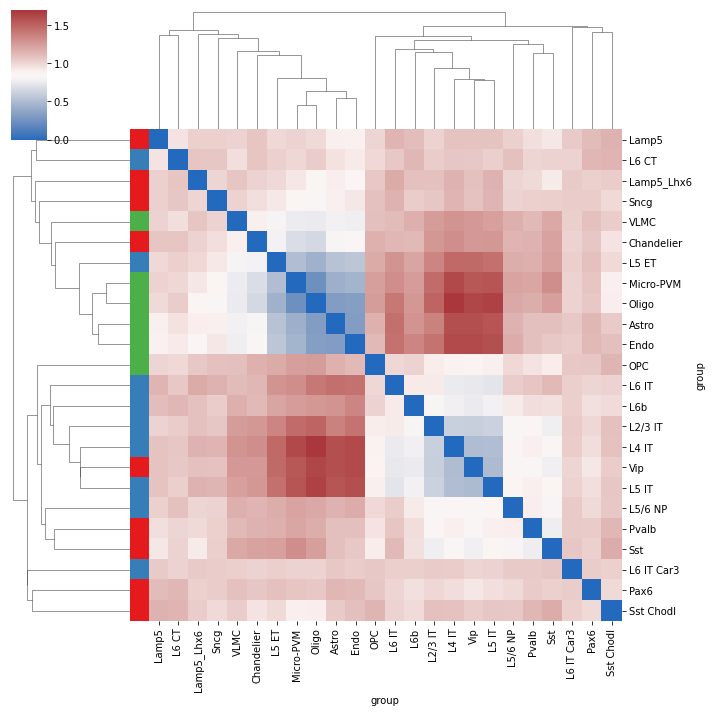

In [188]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-184-04114a00ccd8>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


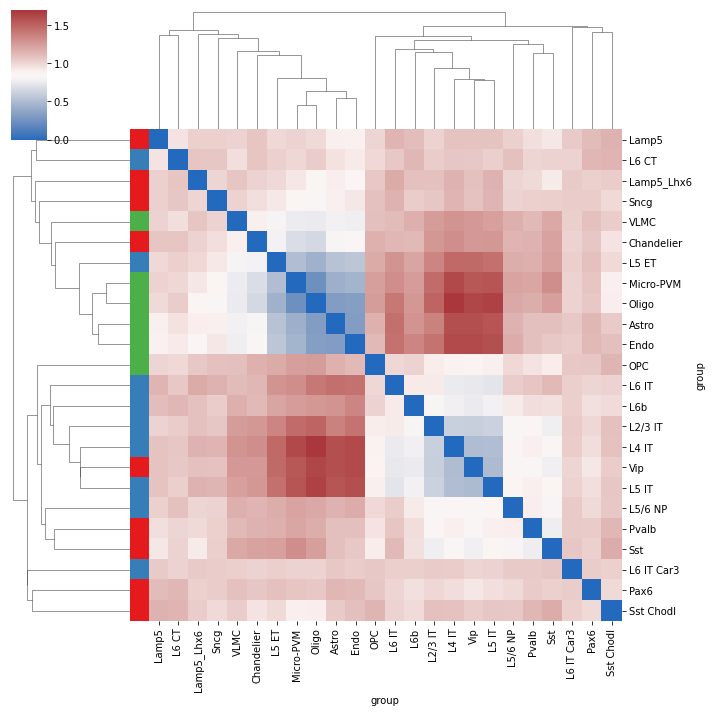

In [184]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-186-4a4eb38d59f9>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


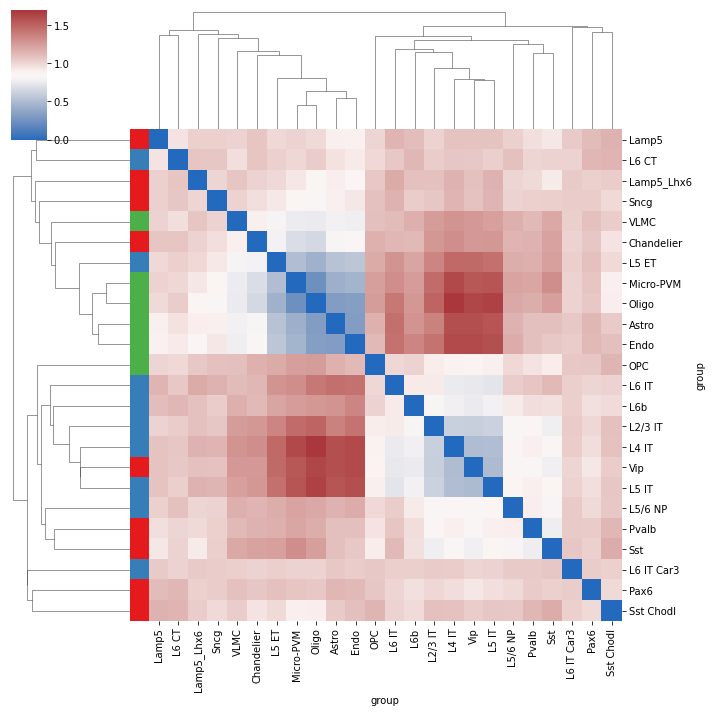

In [186]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
dj = dj[dj['classt']=='Non-neuronal']
#dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [ ]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-163-74f31b1143f4>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


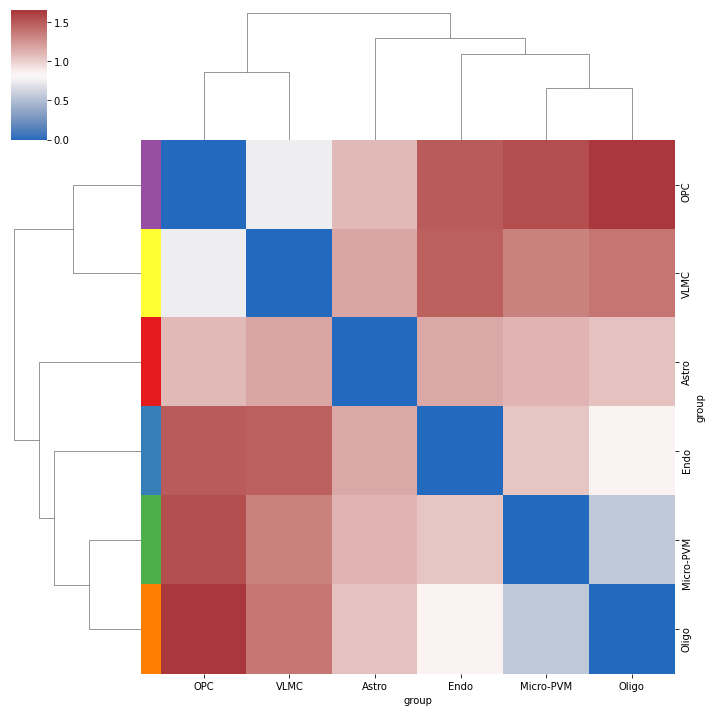

In [163]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [104]:
t[t.isnull().any(axis=1)]

gene  cell_type  rank
65   NaN  L2/3 IT_1    15
138  NaN  L2/3 IT_6    50
484  NaN  L2/3 IT_8   488

<AxesSubplot:xlabel='Ensembl_gene_identifier', ylabel='Count'>

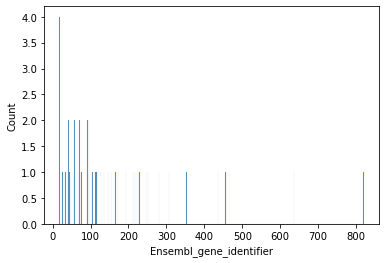

In [31]:
sns.histplot(marker_list.groupby('cell_type')['Ensembl_gene_identifier'].count(), bins=800)

In [ ]:
marker_list.groupby('cell_type')['Ensembl_gene_identifier'].count()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


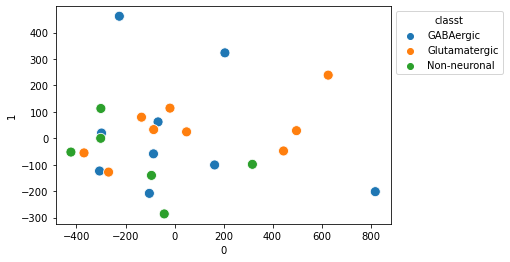

In [4430]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
#dj= dj.groupby(['classt','group']).mean()
dj = df_gene_tp_all_info.groupby(['classt','group']).mean()
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
proj_2da = pca.fit_transform(features_sc)
#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


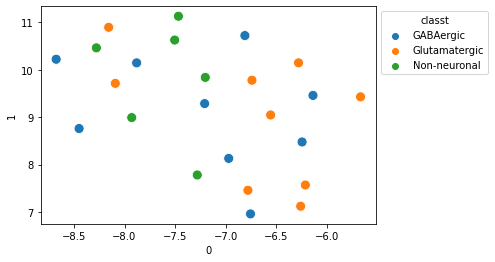

In [4431]:

umap_2d = UMAP(n_components=2, init='random', random_state=1)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


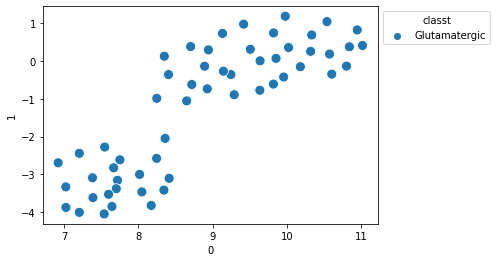

In [4541]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
#dj = dj[dj['classt']=='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
dj = dj[dj['classt']=='Glutamatergic']

from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
#pca = PCA(n_components=2)
#proj_2da = pca.fit_transform(features_sc)
from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#proj_2da = tsne.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


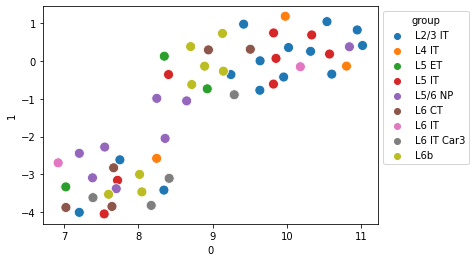

In [4542]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


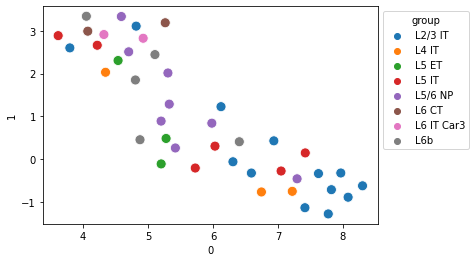

In [4464]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


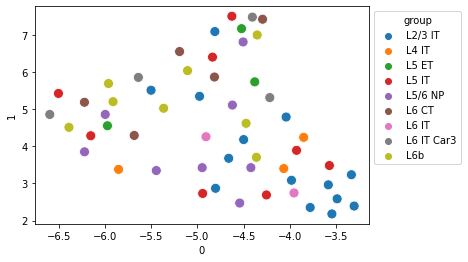

In [4453]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


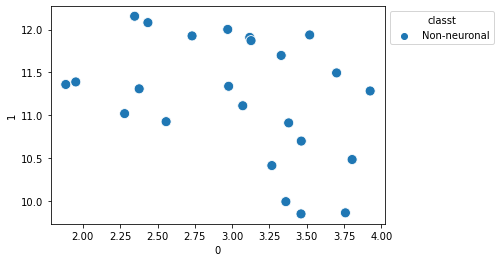

In [4515]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']=='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']

from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
#pca = PCA(n_components=2)
#proj_2da = pca.fit_transform(features_sc)
from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#proj_2da = tsne.fit_transform(features_sc)
umap_2d = UMAP(n_components=4, init='random', random_state=9)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


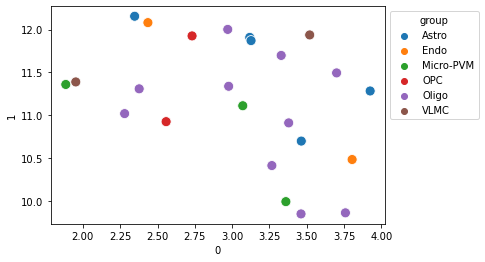

In [4516]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


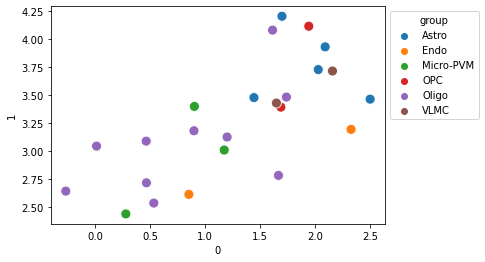

In [4507]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


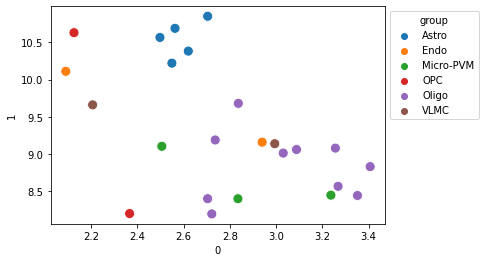

In [4504]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


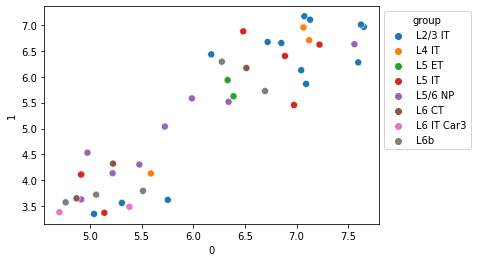

In [4413]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


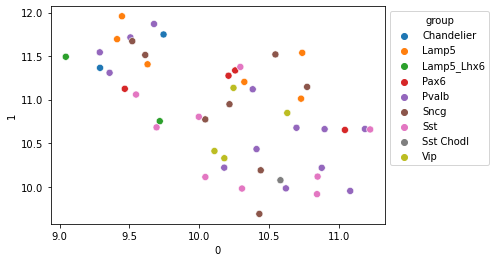

In [4406]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


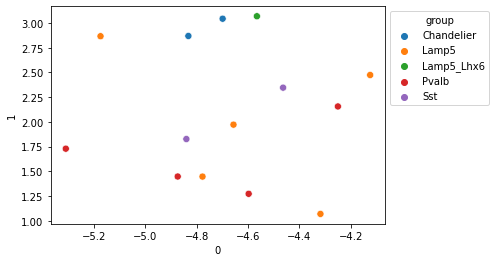

In [4411]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


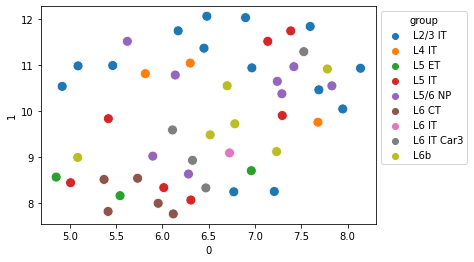

In [4361]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


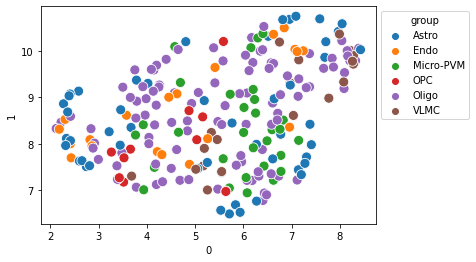

In [4211]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


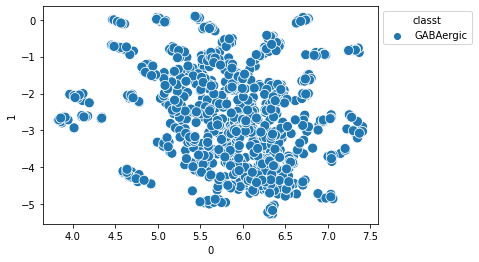

In [4186]:
umap_2d = UMAP(n_components=3, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


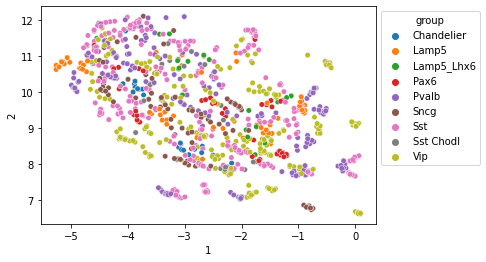

In [4191]:
ax= sns.scatterplot(
    df_proj_2da[1], df_proj_2da[2],
    hue=df_proj_2da['group'],s=30
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


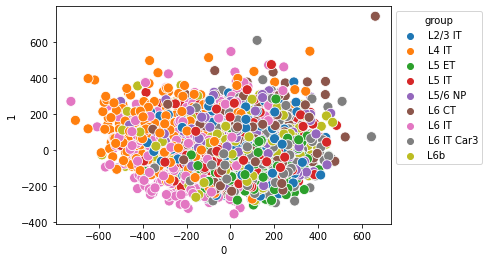

In [4096]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()
df_proj_2da = df_proj_2da[df_proj_2da['classt'] == 'Glutamatergic']


#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


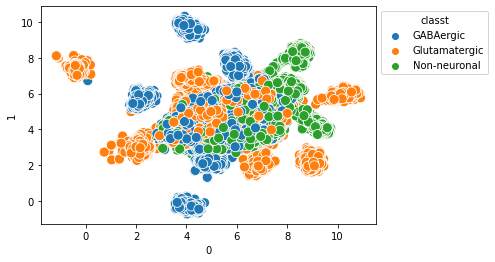

In [4112]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()

#dj = dj[dj['classt']=='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
proj_2da_pc = pca.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



In [4003]:
df_gene_tp_all_info_mean.index.get_level_values('classt') 

Index(['GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'Glutamatergic',
       'Glutamatergic', 'Glutamatergic', 'Glutamatergic', 'Glutamatergic',
       'Glutamatergic', 'Glutamatergic', 'Glutamatergic', 'Glutamatergic',
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal'],
      dtype='object', name='classt')

<ipython-input-4008-62933d56f82c>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


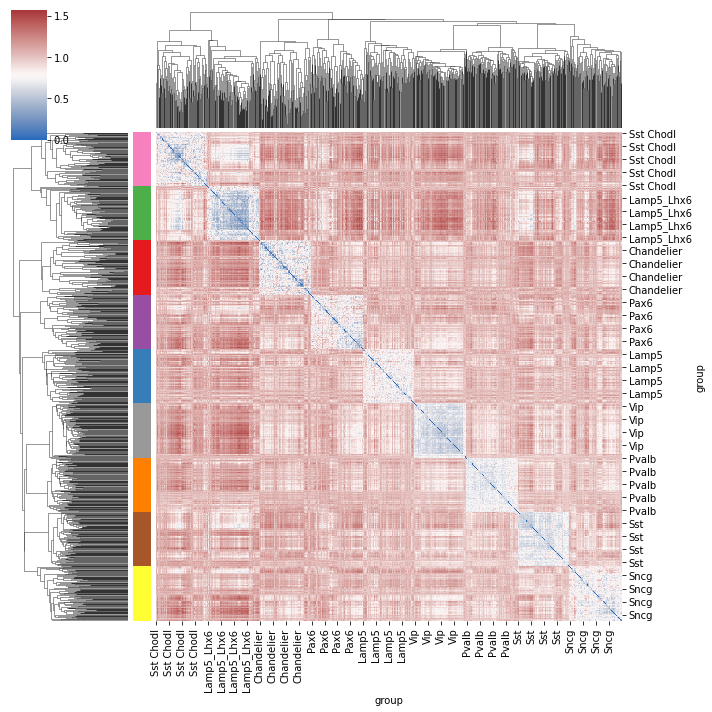

In [4008]:
dj = pd.concat(marker_mean_list)




dj['classy']=dj.index.get_level_values('classt') 
dj=dj[dj['classy']=='GABAergic']

lut = dict(zip( dj.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dj.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dj.index.get_level_values('group').map(lut)

features = dj.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [70]:
kj

NameError: name 'kj' is not defined

<ipython-input-140-74f31b1143f4>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


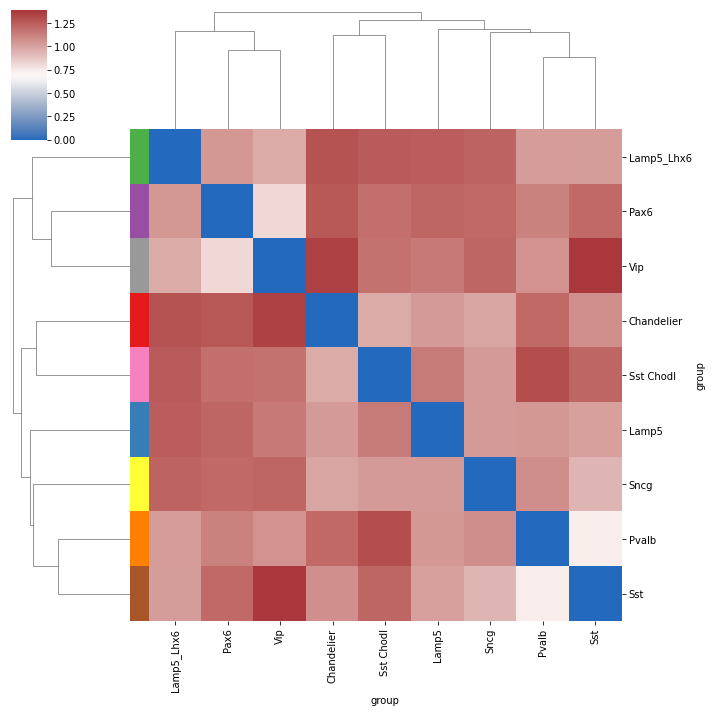

In [140]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-137-74f31b1143f4>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


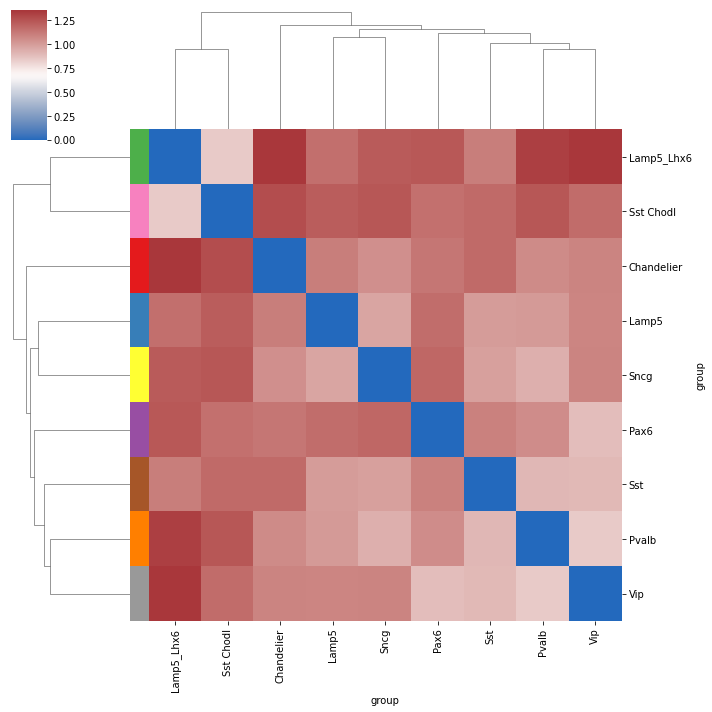

In [137]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-4543-260c1f6055e8>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


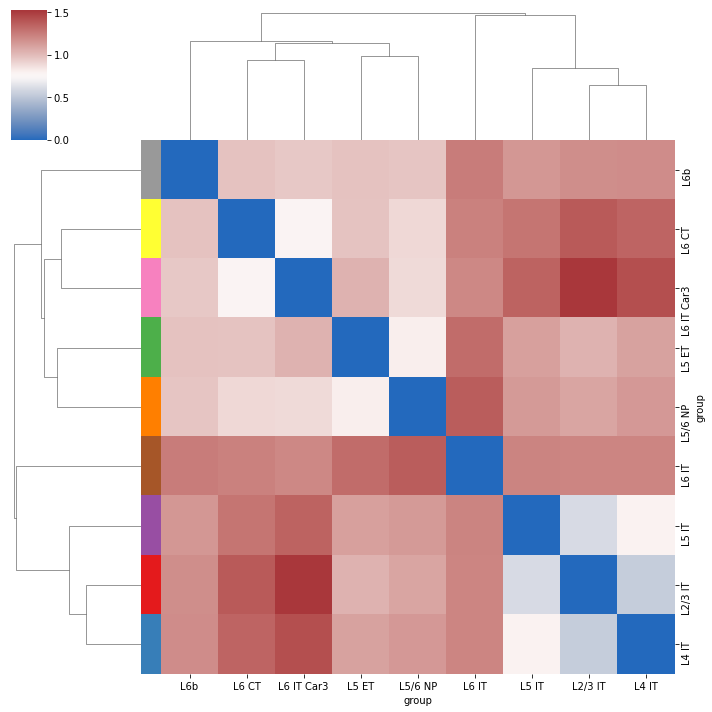

In [4543]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-4201-25efca2cbf3e>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


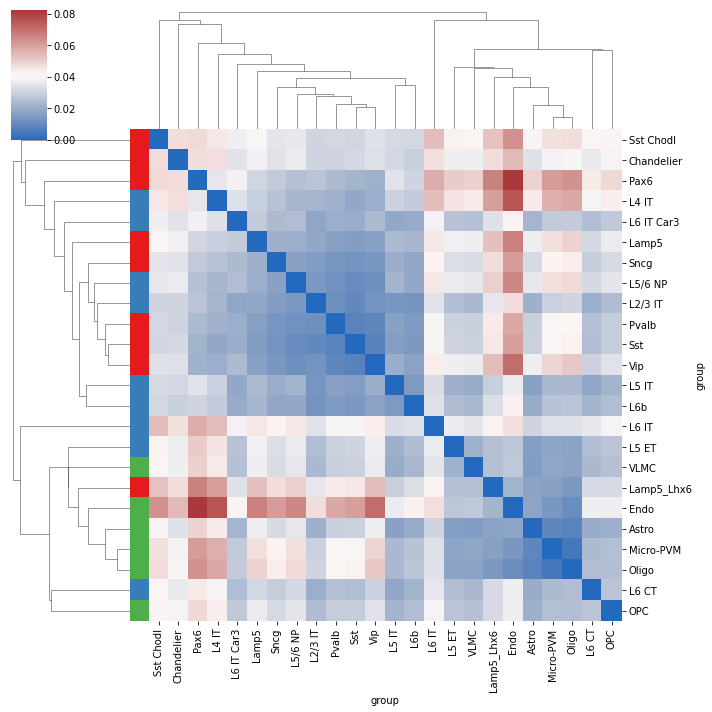

In [4201]:
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [ ]:


lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


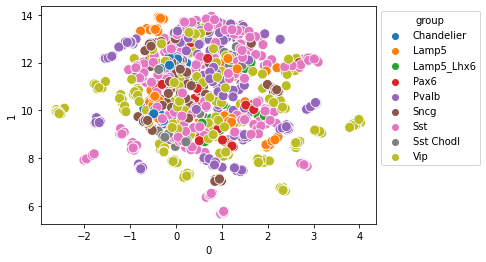

In [4185]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


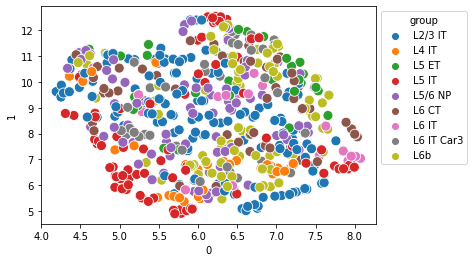

In [4176]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


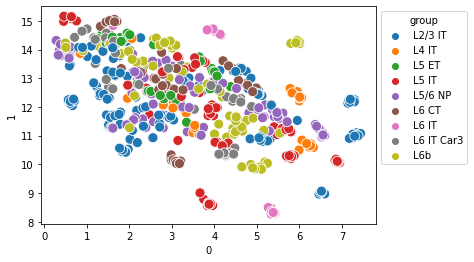

In [4181]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


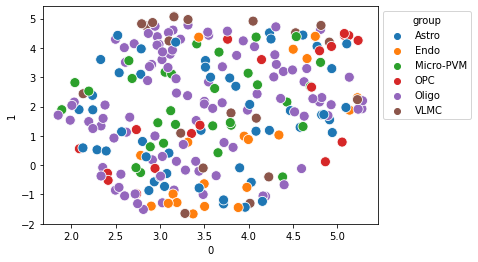

In [4178]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Non-neuronal']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


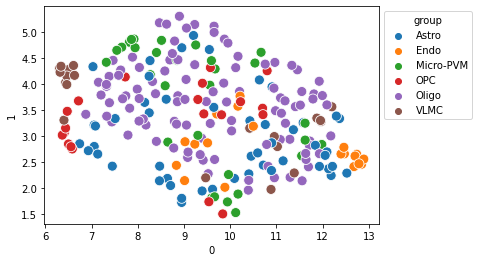

In [4183]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Non-neuronal']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


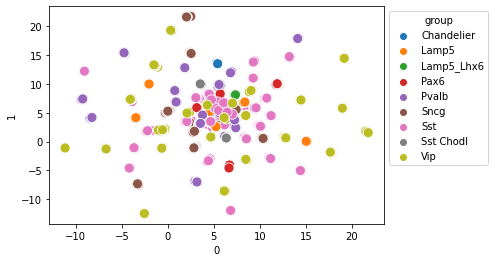

In [4165]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

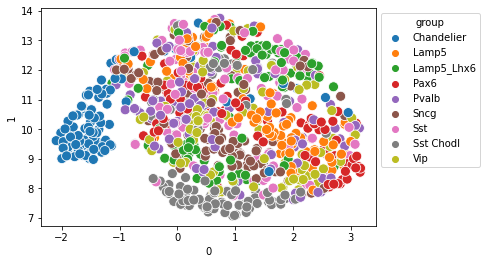

In [4079]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


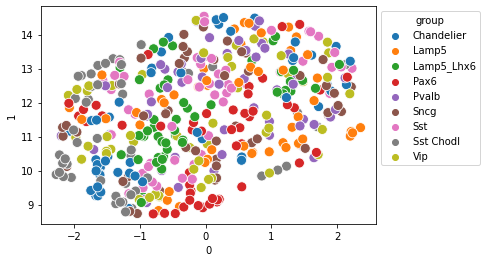

In [4074]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


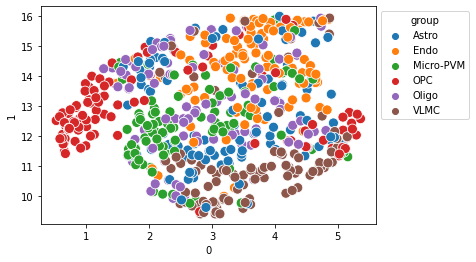

In [4081]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']!='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


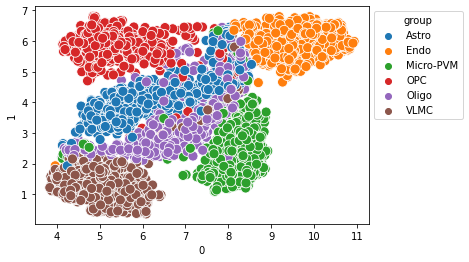

In [4085]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']!='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


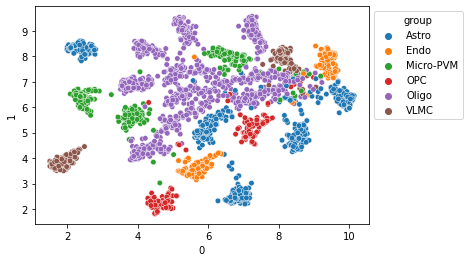

In [4157]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']!='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=30
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()

#dj = dj[dj['classt']=='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
proj_2da_pc = pca.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [ ]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


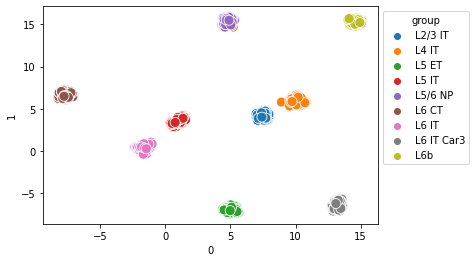

In [3985]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


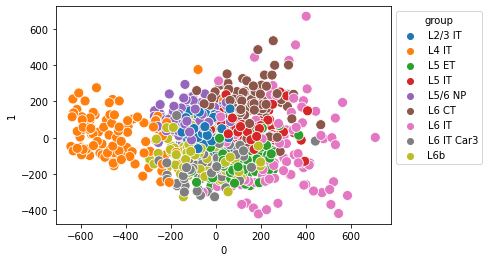

In [3987]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [4124]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features_sc)

df_proj_2da= pd.DataFrame(tsne_results)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 170 samples in 0.079s...
[t-SNE] Computed neighbors for 170 samples in 4.356s...
[t-SNE] Computed conditional probabilities for sample 170 / 170
[t-SNE] Mean sigma: 168.591778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.823906
[t-SNE] KL divergence after 300 iterations: 1.467149


In [4126]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


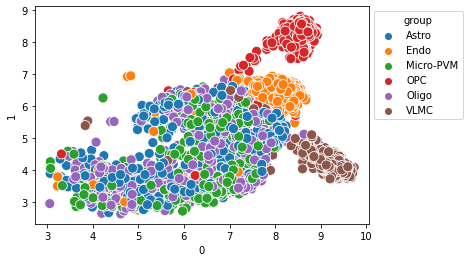

In [4127]:
#df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [3997]:
df_proj_2da= pd.DataFrame(proj_2da_pc)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


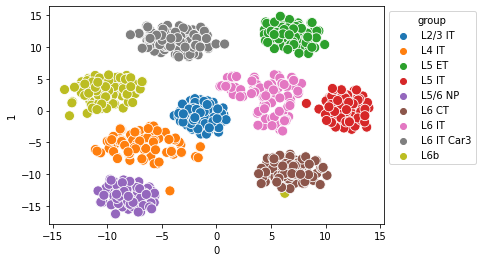

In [3991]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


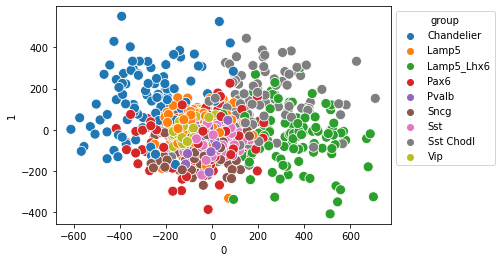

In [3998]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


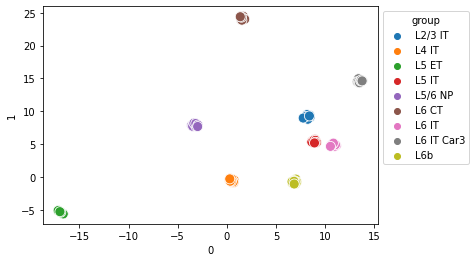

In [3974]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


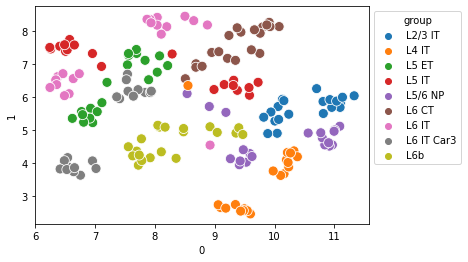

In [3790]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


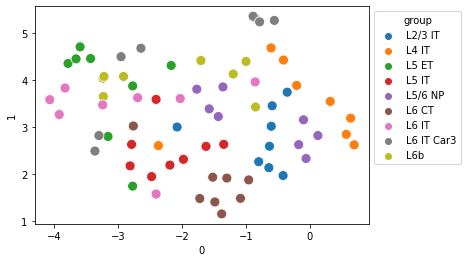

In [3640]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


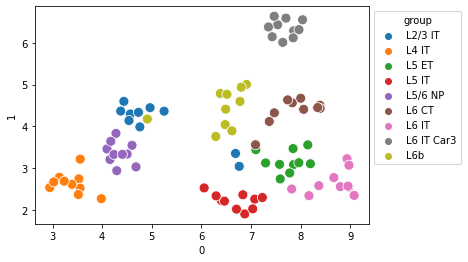

In [3794]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


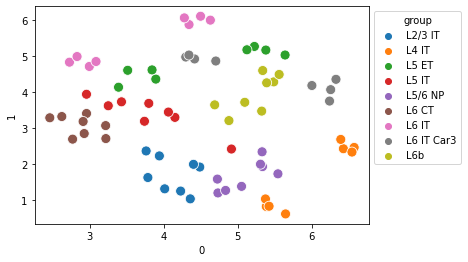

In [3604]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


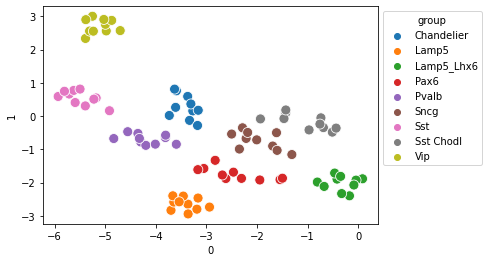

In [3896]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


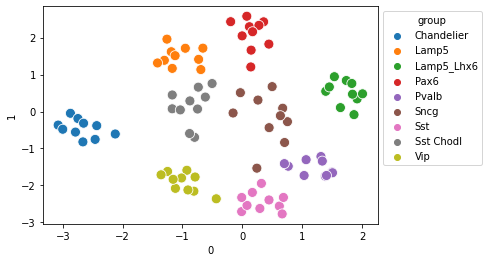

In [3796]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


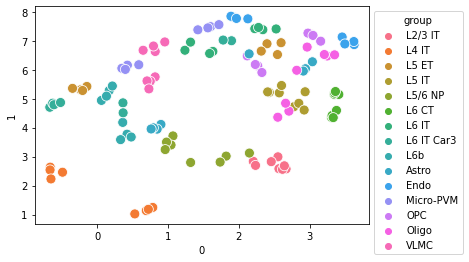

In [3663]:
df_proj_2dt = df_proj_2da[df_proj_2da['classt']!='GABAergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [2224]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2175]:
df = pd.DataFrame({
    'brand': ['Yum Yum', 'Yum Yum', 'Indomie', 'Indomie', 'Indomie'],
    'style': ['cup', 'cup', 'cup', 'pack', 'pack'],
    'rating': [4, 4, 3.5, 15, 5]
})

In [2181]:
df.drop_duplicates(subset=['brand', 'style'])

brand style  rating
0  Yum Yum   cup     4.0
2  Indomie   cup     3.5
3  Indomie  pack    15.0

In [2173]:
mylist = ["apple", "banana", "cherry"]

np.random.choice(mylist, size=10).tolist()

['cherry',
 'cherry',
 'banana',
 'apple',
 'cherry',
 'apple',
 'apple',
 'cherry',
 'cherry',
 'banana']

In [1937]:
df_gene_tp_all_info_mean_group1 = df_gene_tp_all_info.groupby(['classt','group']).mean()


In [1943]:
df_gene_tp_all_info_mean_group2 = df_gene_tp_all_info.groupby(['classt','group']).mean()


In [1332]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [2239]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


In [1716]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [1965]:
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
features = df_gene_tp_all_info_mean.loc[:, human_mouse['human_bin']]


features_sc =  StandardScaler().fit_transform(features)

features_sc_df =  pd.DataFrame(features_sc)

In [1749]:
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, df_gene_tp_o_depth[df_gene_tp_o_depth > 0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)

features_sc_df =  pd.DataFrame(features_sc)

In [1966]:
features_sc_df =  pd.DataFrame(features_sc)

In [2022]:
df_human_mouse_com[df_human_mouse_com['human_bin'].isin(given_bins)]['mouse_bin']

1665        1615
4840        3746
5237        3959
5240        3960
5391        4042
           ...  
376324    243898
379347    245666
379349    245667
380438    246223
380440    246224
Name: mouse_bin, Length: 707, dtype: int64

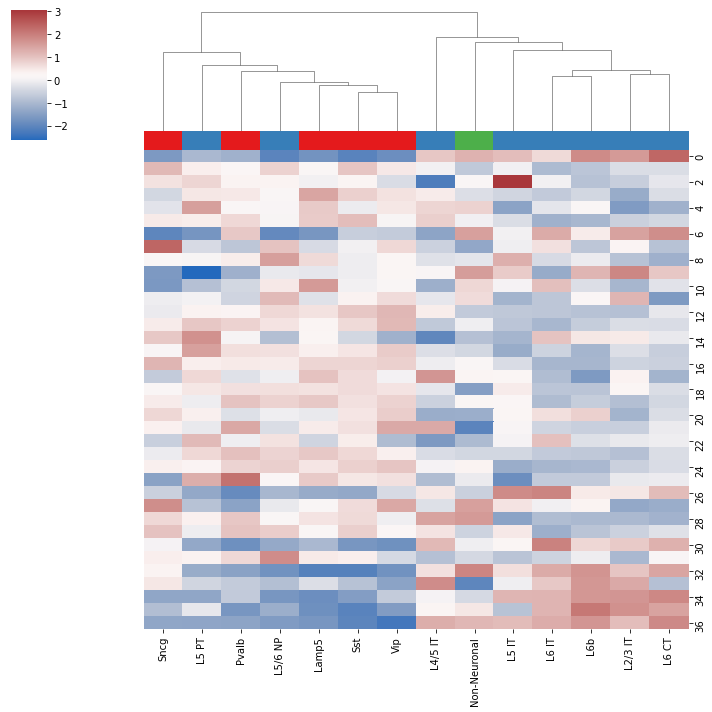

In [2070]:
lut = dict(zip( mouse_10['classt'].drop_duplicates(), sns.color_palette("Set1", mouse_10['classt'].shape[0]).as_hex()[:]))


row_colors =mouse_10['classt'].map(lut)

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    #given_bins = [x for x in given_bins if x in human_mouse['human_bin'].tolist()]
    #given_bins = list(set(given_bins).intersection(set(human_mouse['human_bin'].tolist())))
    given_bins = df_human_mouse_com[df_human_mouse_com['human_bin'].isin(given_bins)]['mouse_bin'].astype('str').tolist()
    #mouse_10.loc[:, df_human_mouse_com['mouse_bin'].astype('str')]
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(mouse_10.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = mouse_10['group'].tolist())

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='vlag')


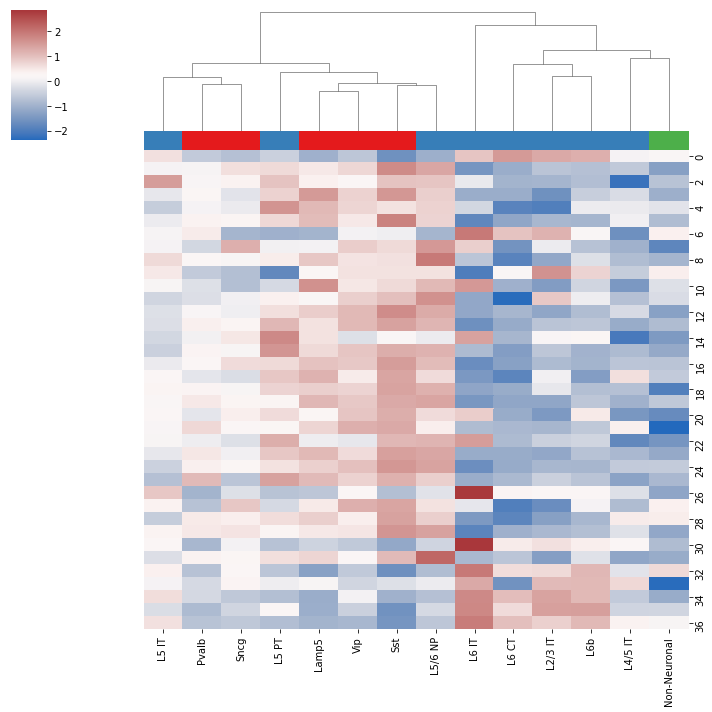

In [2071]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


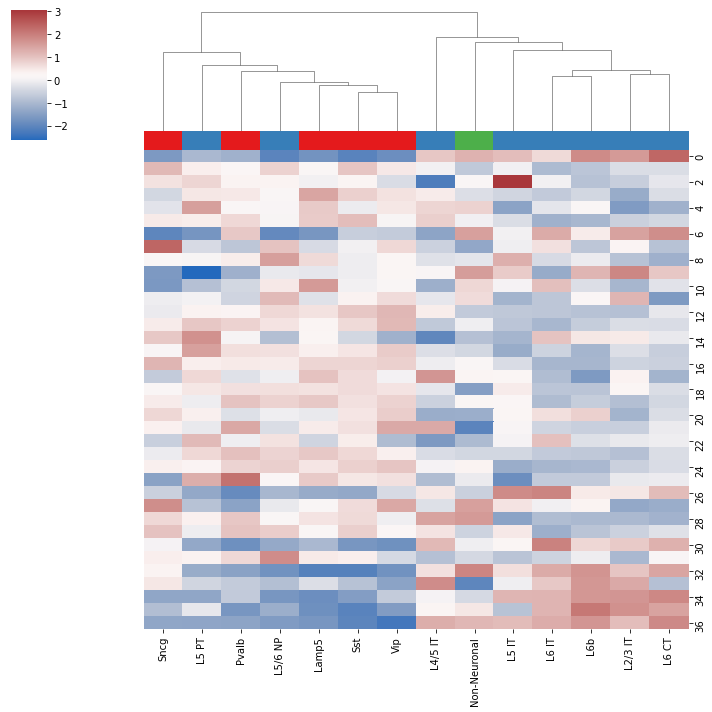

In [2102]:
lut = dict(zip( mouse_10['classt'].drop_duplicates(), sns.color_palette("Set1", mouse_10['classt'].shape[0]).as_hex()[:]))


row_colors =mouse_10['classt'].map(lut)

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    #given_bins = [x for x in given_bins if x in human_mouse['human_bin'].tolist()]
    #given_bins = list(set(given_bins).intersection(set(human_mouse['human_bin'].tolist())))
    given_bins = df_human_mouse_com[df_human_mouse_com['human_bin'].isin(given_bins)]['mouse_bin'].astype('str').tolist()
    #mouse_10.loc[:, df_human_mouse_com['mouse_bin'].astype('str')]
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(mouse_10.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = mouse_10['group'].tolist())

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='vlag')


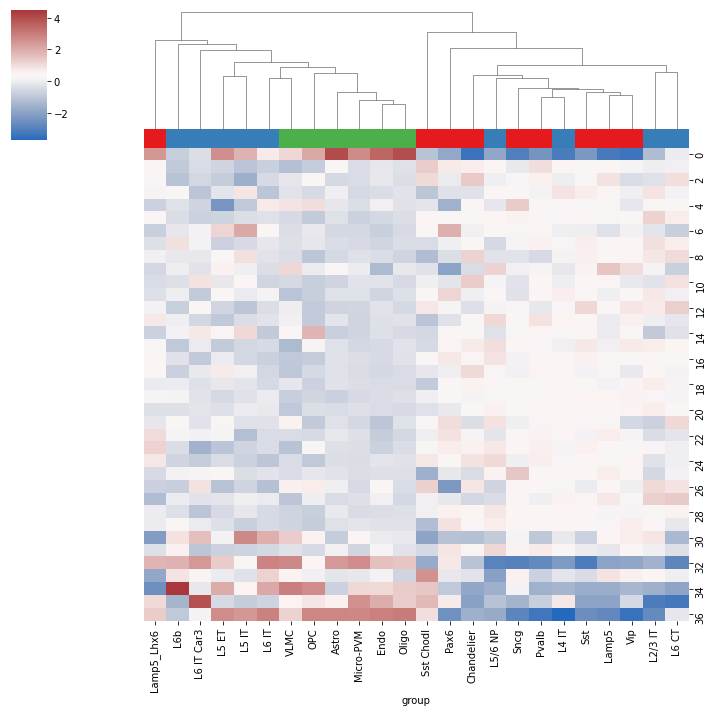

In [2069]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='vlag')


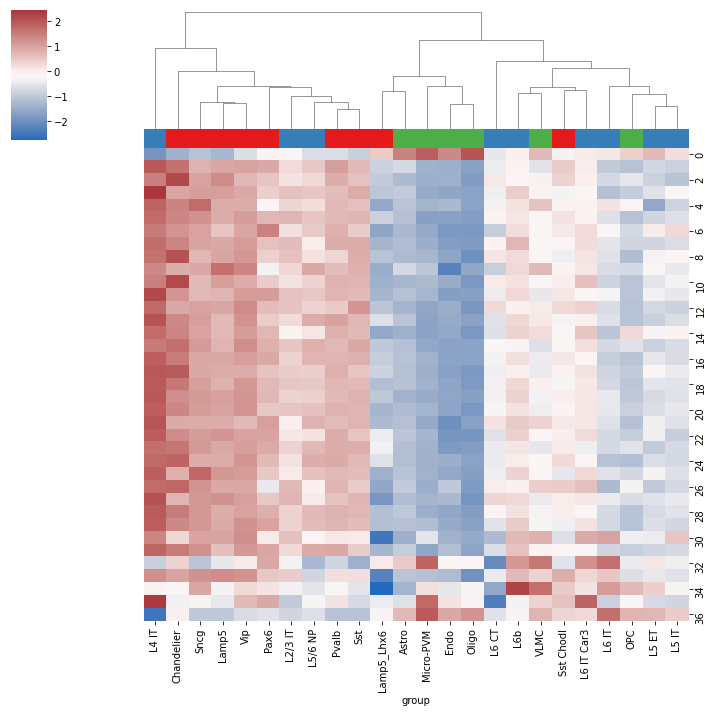

In [2242]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    #given_bins = [x for x in given_bins if x in human_mouse['human_bin'].tolist()]
    given_bins = list(set(given_bins).intersection(set(human_mouse['human_bin'].tolist())))
    #given_bins = 
    #mouse_10.loc[:, df_human_mouse_com['mouse_bin'].astype('str')]
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag')


In [2971]:
dj.loc[: , given_bins]

284       283       532       538       793       815       897     \
0   -0.210555 -0.250314 -0.344083 -0.144828  0.456598  0.849530  0.100855   
1   -0.082733 -0.272926  0.180603  0.374946  0.438761  0.453134  0.616720   
2   -0.295140 -0.125283 -0.183308 -0.383221  1.082629  0.262795  0.683168   
3   -0.033825 -0.251567  0.351080  0.405709  0.697108  0.413754  0.451670   
4   -0.296594 -0.144629  0.007785  0.000031  0.628005  0.326407  0.329739   
..        ...       ...       ...       ...       ...       ...       ...   
109 -0.057821 -0.220524 -0.037395 -0.141673  0.499716  0.113093  0.335307   
110  0.199544  0.326568  0.311138  0.235672  0.944924  0.250798  0.277706   
111 -0.148639  0.045905 -0.245898  0.210570  0.518584  0.913144  0.441150   
112 -0.304135  0.020189  0.050314 -0.227313  0.684705  0.179150  0.509874   
113 -0.390603 -0.034391 -0.032513 -0.181698  0.895490  0.336533  0.465577   

       2361      2496      2499    ...    157026    157506    161079  \
0    0.692066  0.110003  0.310326  ...  0.227269  0.537652 -0.308927   
1    0.180406 -0.122435  0.101119  ...  0.405729  0.842622 -0.467653   
2    0.838968  0.550069  0.882188  ...  1.122063  0.511291 -0.449576   
3    0.693644  0.218757  0.284114  ...  0.724681  0.458442 -0.497395   
4    0.662141  0.189094  0.004647  ...  0.326661  0.468914 -0.107252   
..        ...       ...       ...  ...       ...       ...       ...   
109  0.590636  0.237553  0.172095  ...  0.337353  0.554593 -0.251766   
110  0.822005  0.417717  0.536342  ...  0.156487  0.405778 -0.355483   
111  0.507908  0.202619  0.207283  ...  0.450267  0.534480 -0.246511   
112  0.369009  0.380826  0.028985  ...  0.631481  0.758013 -0.250938   
113  0.427578  0.615014  0.054840  ...  0.663493  0.590356 -0.282242   

       161459    162544    163291    163561    164849    165138    166900  
0    0.735371  0.029486  1.060034  0.231346  0.631421  2.227446  0.231842  
1    0.061773  0.231952  1.486932  0.195860  0.562205  1.166996  0.359981  
2   -0.003671  0.557378  0.998440  0.462439  0.820152  0.185276  0.487078  
3    0.012673 -0.146419  0.505379  0.322263  0.567015  0.377428  0.554440  
4   -0.094913  0.068298  0.590214  0.284730  0.436018  0.394233  0.359851  
..        ...       ...       ...       ...       ...       ...       ...  
109  0.140057  0.017209  0.733668  0.226893  0.232708  0.382380  0.623325  
110  0.096995  0.172527  0.461067  0.176441  0.336736  0.441929  0.938843  
111 -0.024835  0.151850  0.813080  0.200798  1.032415  0.807907  0.378665  
112  0.165413  0.450334  0.769488  0.439986  0.261100  0.442331  0.542020  
113  0.208985  0.291372  0.607112  0.513093  0.347788  0.709294  0.324731  

[90 rows x 559 columns]

In [2976]:
dj.groupby(['classt','group']).mean()

0         1         2         3         4       \
classt        group                                                          
GABAergic     Chandelier -1.492414 -0.690637 -1.311786 -1.002175 -0.990968   
              Lamp5      -1.491846 -0.918687 -1.313992 -1.223772 -1.113335   
              Lamp5_Lhx6 -1.216331 -0.578357 -0.987094 -0.944361 -0.936937   
              Pax6       -1.361941 -0.880020 -1.239156 -1.082617 -1.077891   
              Pvalb      -1.431646 -0.824487 -1.268957 -1.113221 -1.054030   
              Sncg       -1.370476 -0.829103 -1.260881 -1.105342 -1.058029   
              Sst        -1.367415 -0.807854 -1.224998 -1.007921 -0.959950   
              Sst Chodl  -1.426569 -0.996307 -1.178563 -1.132442 -1.193603   
              Vip        -1.457882 -0.936977 -1.297802 -1.159302 -1.114222   
Glutamatergic L2/3 IT    -1.398546 -0.809120 -1.247852 -1.056058 -1.036273   
              L4 IT      -1.550317 -0.960183 -1.439120 -1.129837 -1.212886   
              L5 ET      -1.372404 -0.617160 -1.221938 -1.044575 -0.865726   
              L5 IT      -1.361854 -0.748419 -1.169720 -1.002669 -0.956383   
              L5/6 NP    -1.365543 -0.759026 -1.192477 -1.039402 -1.013819   
              L6 CT      -1.278552 -0.435726 -1.055944 -0.847069 -0.910048   
              L6 IT      -1.461636 -0.790733 -1.278499 -1.062509 -1.053501   
              L6 IT Car3 -1.493585 -0.768188 -1.218603 -0.971366 -1.133641   
              L6b        -1.466978 -1.008603 -1.339496 -1.133177 -1.151399   

                            5         6         7         8         9       \
classt        group                                                          
GABAergic     Chandelier -0.173576 -0.315265 -0.753848 -0.277463 -0.853220   
              Lamp5      -0.503142 -0.582781 -0.915266 -0.662881 -0.943417   
              Lamp5_Lhx6 -0.364052 -0.443857 -0.559570 -0.415689 -0.640169   
              Pax6       -0.298011 -0.653863 -0.737539 -0.460420 -0.853991   
              Pvalb      -0.450590 -0.569157 -0.700152 -0.382503 -0.815143   
              Sncg       -0.407765 -0.426740 -0.743809 -0.406553 -0.747065   
              Sst        -0.227440 -0.338647 -0.606009 -0.209706 -0.628647   
              Sst Chodl  -0.605153 -0.644837 -0.802637 -0.437478 -0.964432   
              Vip        -0.495872 -0.601974 -0.783836 -0.502875 -0.814180   
Glutamatergic L2/3 IT    -0.419003 -0.494336 -0.721932 -0.392688 -0.756603   
              L4 IT      -0.704501 -0.668839 -0.944808 -0.547863 -0.924092   
              L5 ET       0.162906 -0.002687 -0.340642  0.918183 -0.422838   
              L5 IT      -0.139287 -0.151799 -0.587726 -0.147442 -0.475209   
              L5/6 NP    -0.449656 -0.529909 -0.708851 -0.299046 -0.704606   
              L6 CT      -0.188373 -0.396855 -0.602940 -0.249244 -0.656847   
              L6 IT      -0.563416 -0.369177 -0.679750 -0.399662 -0.786237   
              L6 IT Car3 -0.047396 -0.179655 -0.595885 -0.099128 -0.814766   
              L6b        -0.433036 -0.522308 -0.855734 -0.430851 -0.732807   

                          ...    287499    287500    287501    287502  \
classt        group       ...                                           
GABAergic     Chandelier  ... -1.103921 -1.183013 -1.271170 -1.441867   
              Lamp5       ... -1.099749 -1.312197 -1.269232 -1.459647   
              Lamp5_Lhx6  ... -0.902501 -1.122348 -0.996233 -1.210180   
              Pax6        ... -1.020114 -1.244029 -1.140049 -1.345399   
              Pvalb       ... -1.085077 -1.271816 -1.131021 -1.422301   
              Sncg        ... -1.041944 -1.225896 -1.175552 -1.358084   
              Sst         ... -1.025573 -1.212382 -1.138301 -1.310892   
              Sst Chodl   ... -1.085145 -1.325164 -1.269073 -1.423931   
              Vip         ... -1.151273 -1.315127 -1.238024 -1.458771   
Glutamatergic L2/3 IT     ... -1.105244 -1.274097 -1.221315 -1.395319   
              L4 IT       ... 

In [2974]:
dj

classt       group         0         1         2         3  \
0        GABAergic  Chandelier -1.430703 -0.869567 -1.197268 -1.005127   
1        GABAergic       Lamp5 -1.499969 -0.948588 -1.334574 -1.261102   
2        GABAergic  Lamp5_Lhx6 -1.169148 -0.690368 -0.992624 -0.876410   
3        GABAergic        Pax6 -1.333550 -0.737965 -1.194785 -1.132666   
4        GABAergic       Pvalb -1.437052 -0.618919 -1.296192 -1.114055   
..             ...         ...       ...       ...       ...       ...   
109  Glutamatergic     L5/6 NP -1.316347 -0.741928 -1.148056 -1.042296   
110  Glutamatergic       L6 CT -1.247919 -0.727776 -1.099370 -0.995816   
111  Glutamatergic       L6 IT -1.498320 -0.643769 -1.348861 -1.066934   
112  Glutamatergic  L6 IT Car3 -1.470305 -0.836074 -1.188762 -1.007079   
113  Glutamatergic         L6b -1.472842 -1.106192 -1.320099 -1.242358   

            4         5         6         7  ...    287499    287500  \
0   -1.000553 -0.326753 -0.508182 -0.686105  ... -1.079534 -1.192694   
1   -1.114712 -0.503507 -0.513057 -0.876722  ... -1.133566 -1.289624   
2   -0.954972 -0.545311 -0.654952 -0.753805  ... -0.862402 -1.086867   
3   -1.061749 -0.176308 -0.575516 -0.739108  ... -0.901000 -1.248413   
4   -1.047573 -0.393527 -0.604561 -0.815655  ... -1.046274 -1.296838   
..        ...       ...       ...       ...  ...       ...       ...   
109 -1.002002 -0.488868 -0.637330 -0.657376  ... -0.914111 -1.019472   
110 -0.914234 -0.238116 -0.510928 -0.670699  ... -0.959963 -1.095808   
111 -1.138362 -0.600373 -0.500110 -0.815343  ... -1.189529 -1.313992   
112 -1.194882  0.113395 -0.244160 -0.455877  ... -1.159927 -1.288544   
113 -1.134505 -0.314261 -0.630975 -0.901498  ... -1.093497 -1.347789   

       287501    287502    287503    287504    287505    287506    287507  \
0   -1.238562 -1.430703 -1.018380 -0.316041 -0.564762 -0.377195 -1.022954   
1   -1.287074 -1.470035 -0.703524  0.161597  0.320525 -0.247723 -1.197728   
2   -0.966332 -1.157357 -0.736333  0.452816 -0.053223  0.055117 -0.830739   
3   -1.114510 -1.320690 -0.562503  0.422720 -0.274590 -0.221194 -1.033359   
4   -1.207636 -1.409723 -0.637630  0.140981 -0.310396 -0.320903 -0.246345   
..        ...       ...       ...       ...       ...       ...       ...   
109 -1.101251 -1.298076 -0.595438  0.407503 -0.064613 -0.056200 -0.932207   
110 -1.066014 -1.263727 -0.308140  0.331970 -0.291771 -0.429128 -0.894795   
111 -1.245717 -1.532208 -1.040590 -0.061917 -0.340565 -0.563808 -1.024925   
112 -1.161099 -1.495953 -0.886071  0.353459 -0.261036 -0.181742 -1.013468   
113 -1.254506 -1.483229 -0.859549 -0.179033 -0.486755 -0.708642 -0.953599   

       287508  
0   -1.430703  
1   -1.488325  
2   -1.157357  
3   -1.334269  
4   -1.436576  
..        ...  
109 -1.326999  
110 -1.283899  
111 -1.532208  
112 -1.495953  
113 -1.483229  

[90 rows x 287511 columns]

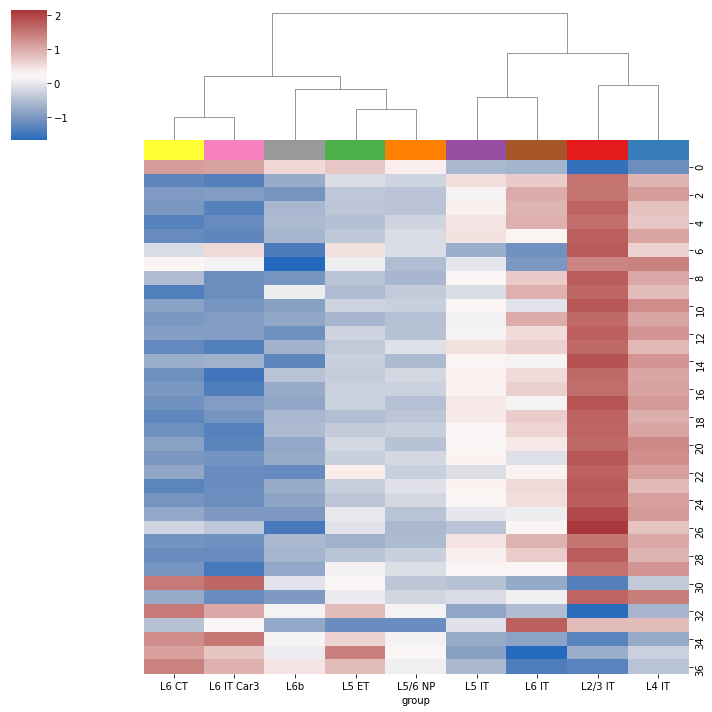

In [4546]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


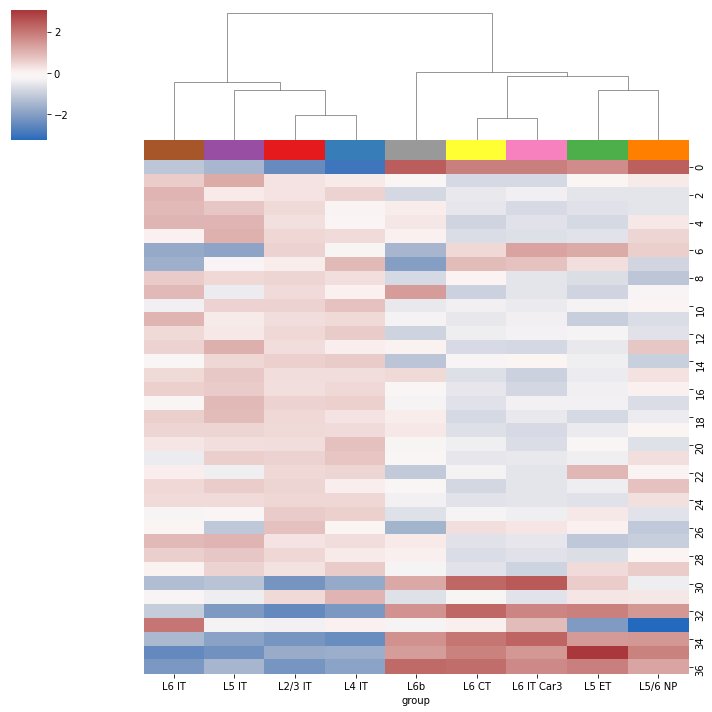

In [4547]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='vlag')


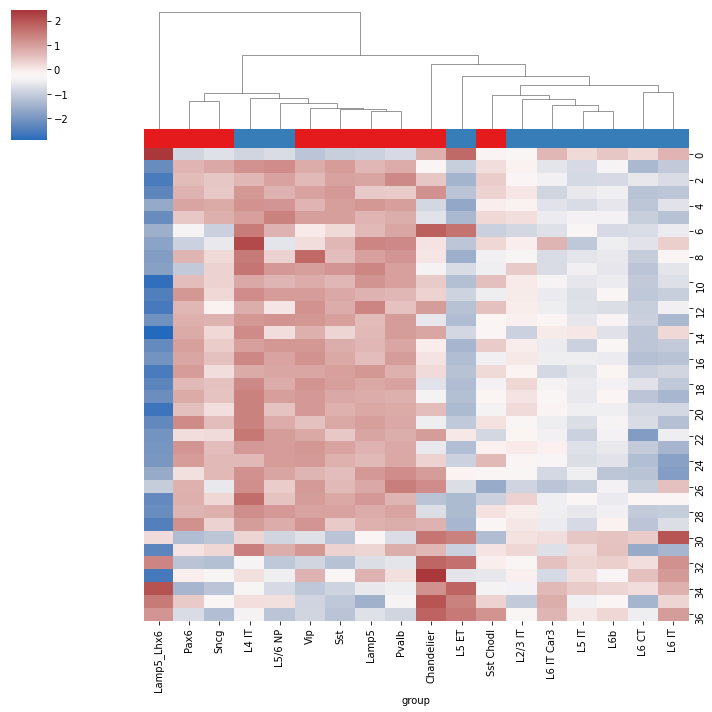

In [4204]:
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


In [4140]:
#dj = pd.concat(marker_mean_list)
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



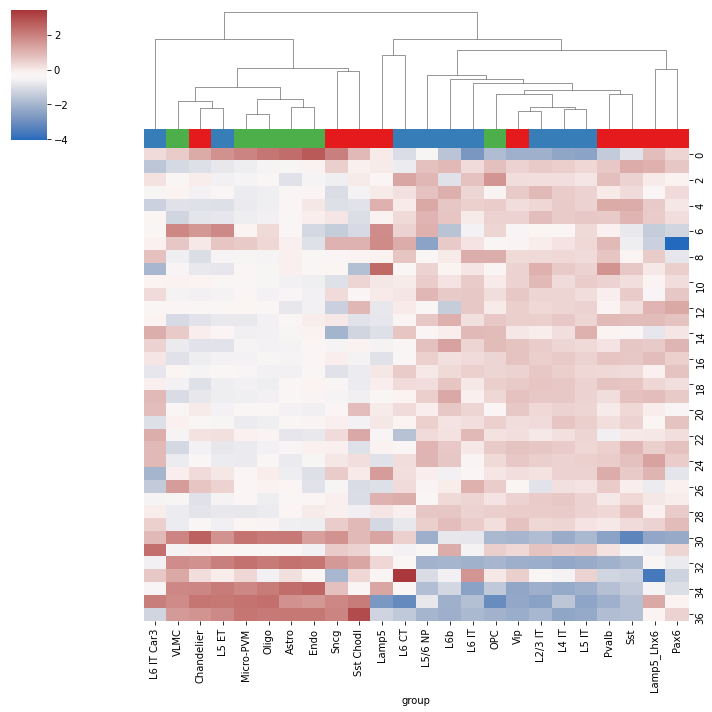

In [4142]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='vlag')



In [2254]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)




In [2255]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

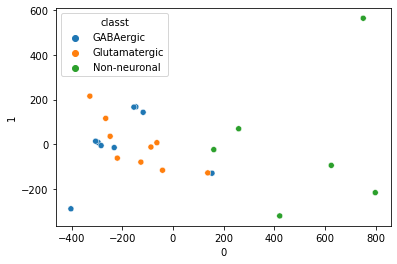

In [2251]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

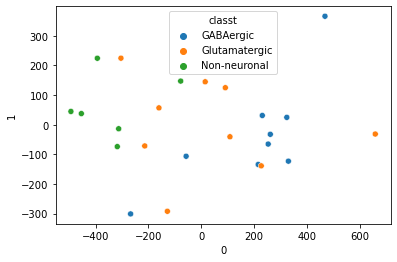

In [2256]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [1973]:
mouse_10 = pd.read_csv('./mouse_10.csv')

In [2115]:
df_human_mouse_com = pd.read_csv("./dell.bed", sep='\t', names = ['chrm', 'st', 'end', 'mouse_bin', 'chrme', 'ste', 'ende', 'human_bin'])



In [2064]:
human_mouse = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.5.bed', sep='\t', names = ['chrm', 'st', 'end', 'human_bin'])



In [2162]:
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
#features = df_gene_tp_all_info_mean.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features_h = df_gene_tp_all_info_mean.loc[:, df_human_mouse_com['human_bin']].head(18)
features_m = mouse_10.loc[:, df_human_mouse_com['mouse_bin'].astype('str')].head(12)
features_h_n = stats.zscore(features_h,axis=0, nan_policy='omit')  
features_m_n = stats.zscore(features_m,axis=0, nan_policy='omit')
features = pd.DataFrame(np.vstack([features_h_n, features_m_n]), columns=features_m.columns)
#features = features.loc[:, features [features  > 0 ].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

features_sc_df =  pd.DataFrame(features_sc)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
proj_2d = pca.fit_transform(features_sc)


In [2152]:
umap_2d = UMAP(n_components=10, init='random', random_state=2)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


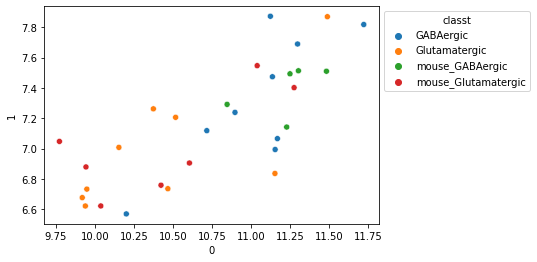

In [2153]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('classt').tolist() + ['mouse_' + x for x in mouse_10['classt'].head(12).tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('group').tolist() + mouse_10['group'].head(12).tolist()
ax= sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


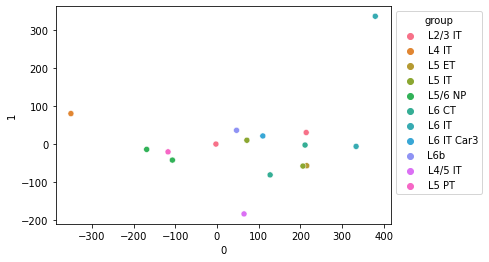

In [2170]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('classt').tolist() + ['' + x for x in mouse_10['classt'].head(12).tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('group').tolist() + mouse_10['group'].head(12).tolist()
df_proj_2d = df_proj_2d[df_proj_2d['classt']=='Glutamatergic']
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

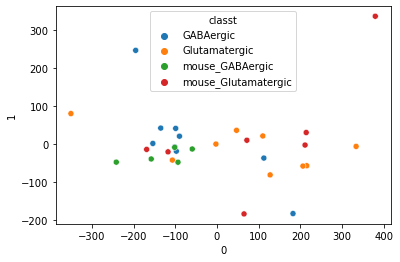

In [2169]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('classt').tolist() + ['mouse_' + x for x in mouse_10['classt'].head(12).tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('group').tolist() + mouse_10['group'].head(12).tolist()
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)


In [ ]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('classt').tolist() + ['mouse_' + x for x in mouse_10['classt'].head(12).tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('group').tolist() + mouse_10['group'].head(12).tolist()
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='2'>

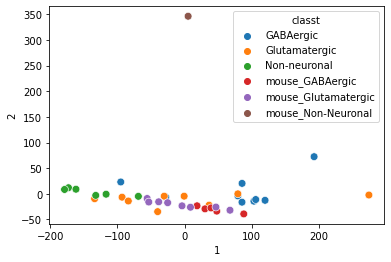

In [2120]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt').tolist() + ['mouse_' + x for x in mouse_10['classt'].tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group').tolist() + mouse_10['group'].tolist()
sns.scatterplot(
    df_proj_2d[1],df_proj_2d[2],
    hue=df_proj_2d['classt'], s=60
)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='2'>

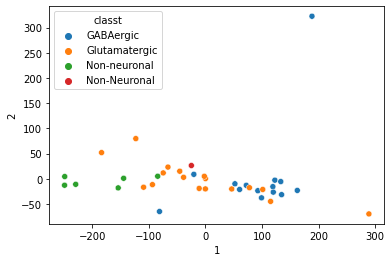

In [2073]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt').tolist() + mouse_10['classt'].tolist()
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group').tolist() + mouse_10['group'].tolist()
sns.scatterplot(
    df_proj_2d[1],df_proj_2d[2],
    hue=df_proj_2d['classt'],
)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='2'>

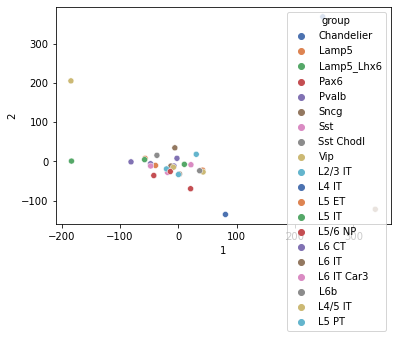

In [2164]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('classt').tolist() + [x for x in mouse_10['classt'].head(12).tolist()]
df_proj_2d['group'] = df_gene_tp_all_info_mean.head(18).index.get_level_values('group').tolist() + mouse_10['group'].head(12).tolist()
#df_proj_2d = df_proj_2d[df_proj_2d['classt']=='Glutamatergic']
sns.scatterplot(
    df_proj_2d[1],df_proj_2d[2],
    hue=df_proj_2d['group'], palette='deep'
)

In [2053]:
df_proj_2d

0           1           2         classt       group
9  -367.809529   85.160929  -34.368513  Glutamatergic     L2/3 IT
10 -441.874266  503.197825 -125.787420  Glutamatergic       L4 IT
11 -317.788030 -184.917276  -30.850256  Glutamatergic       L5 ET
12 -305.844126 -155.166937  -22.109547  Glutamatergic       L5 IT
13 -379.083603  212.222356  -68.726295  Glutamatergic     L5/6 NP
14 -273.710120    1.354254  -36.929337  Glutamatergic       L6 CT
15 -305.611794 -308.439241   64.280442  Glutamatergic       L6 IT
16 -354.743949  -67.036658    0.081458  Glutamatergic  L6 IT Car3
17 -380.217004    4.815636   -3.664002  Glutamatergic         L6b
29  626.586440 -136.625452   33.440604  Glutamatergic     L2/3 IT
30  610.273424    1.372500  -30.355484  Glutamatergic     L4/5 IT
31  609.308226  -15.286760    4.280766  Glutamatergic       L5 IT
32  572.367388  128.356419  -28.337438  Glutamatergic       L5 PT
33  566.385788  170.158095  -34.326612  Glutamatergic     L5/6 NP
34  614.761444 -145.179406   18.474315  Glutamatergic       L6 CT
35  658.769819 -241.454664  107.761151  Glutamatergic       L6 IT
36  626.881256 -102.131274   21.633543  Glutamatergic         L6b

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='2'>

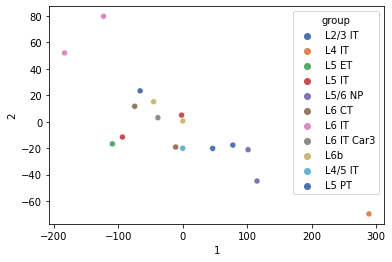

In [2098]:
df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt').tolist() + mouse_10['classt'].tolist()
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group').tolist() + mouse_10['group'].tolist()
df_proj_2d = df_proj_2d[df_proj_2d['classt']=='Glutamatergic']
sns.scatterplot(
    df_proj_2d[1],df_proj_2d[2],
    hue=df_proj_2d['group'], palette='deep'
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='2'>

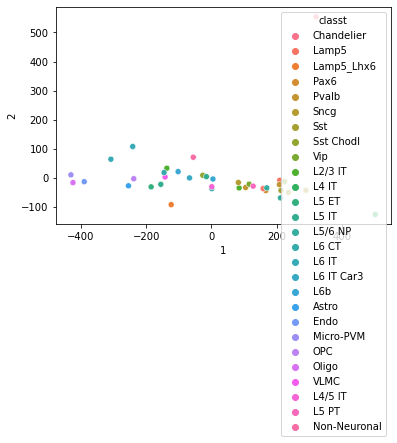

In [2015]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('group').tolist() + mouse_10['group'].tolist()
sns.scatterplot(
    df_proj_2d[1],df_proj_2d[2],
    hue=df_proj_2d['classt'],
)


In [2005]:
df_gene_tp_all_info_mean.index.get_level_values('classt').tolist()

['GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'GABAergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Glutamatergic',
 'Non-neuronal',
 'Non-neuronal',
 'Non-neuronal',
 'Non-neuronal',
 'Non-neuronal',
 'Non-neuronal']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

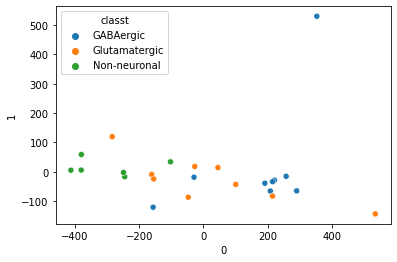

In [1980]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

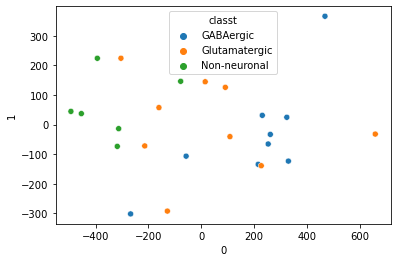

In [1956]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

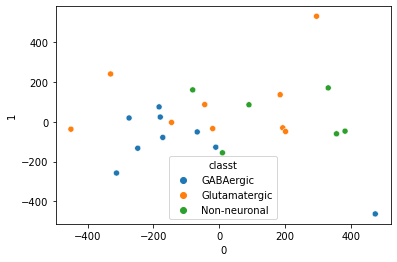

In [1740]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [1229]:
dj = pd.concat([df_gene_tp_all_info_mean_group1, df_gene_tp_all_info_mean_group2])

In [1230]:
pd.

0         1         2         3         4       \
classt        group                                                          
GABAergic     Chandelier -1.576432 -1.235487 -1.405960 -1.055667 -1.405960   
              Lamp5      -1.494272 -0.762172 -1.175974 -1.074044 -1.101019   
              Lamp5_Lhx6 -1.049722 -0.847025 -1.049722 -0.948374 -0.803453   
              Pax6       -1.556101 -0.771172 -1.041191 -0.554017 -1.224298   
              Pvalb      -1.407807 -0.901066 -1.202894 -1.052213 -0.975804   
              Sncg       -1.420413 -0.940427 -1.196808 -1.152733 -1.099942   
              Sst        -1.393680 -0.848060 -1.190992 -1.106587 -1.021532   
              Sst Chodl  -1.397094 -0.870701 -1.210296 -0.896848 -1.119775   
              Vip        -1.449995 -0.937508 -1.292085 -1.138199 -1.148414   
Glutamatergic L2/3 IT    -1.404579 -0.638021 -1.265278 -1.102421 -0.985091   
              L4 IT      -1.396767 -0.900721 -1.209773 -1.006647 -1.010099   
              L5 ET      -1.305791 -0.707045 -1.274118 -1.053248 -0.946085   
              L5 IT      -1.502577 -0.606695 -1.192523 -1.042738 -1.073032   
              L5/6 NP    -1.416510 -0.865566 -1.329347 -1.136723 -0.995366   
              L6 CT      -1.297480 -0.834239 -1.034132 -0.950802 -0.915447   
              L6 IT      -1.158515 -0.885118 -1.158515 -0.885118 -0.885118   
              L6 IT Car3 -1.558232 -0.914792 -1.498292 -1.210869 -1.369367   
              L6b        -1.369333 -0.783052 -1.167623 -0.937553 -1.012609   
Non-neuronal  Astro      -1.342780 -0.834461 -1.264517 -1.101417 -1.092141   
              Endo       -1.343520  3.266836 -1.048186  0.645273 -0.667461   
              Micro-PVM  -1.561877 -1.013317 -1.259455 -1.273468 -0.896690   
              OPC        -0.939089 -0.612408 -0.844974 -0.662756 -0.701005   
              Oligo      -1.380514 -0.640042 -1.146495 -0.987329 -1.041191   
              VLMC       -1.405610 -0.884268 -1.343218 -1.000728 -1.076480   
GABAergic     Chandelier -1.743490 -1.333696 -1.333696 -1.333696 -1.333696   
              Lamp5      -1.331835 -0.785690 -1.168872 -1.056631 -0.881902   
              Lamp5_Lhx6 -1.519867 -0.688870 -1.328038 -1.318809 -0.938489   
              Pax6       -1.554283 -0.811402 -1.410809 -1.234387 -1.214415   
              Pvalb      -1.480802 -1.076168 -1.377420 -1.170991 -1.147101   
              Sncg       -1.518877 -0.979824 -1.463667 -1.234292 -1.228649   
              Sst        -1.472397 -1.011132 -1.302859 -1.162328 -1.121585   
              Sst Chodl  -1.441904 -1.289082 -1.441904 -1.136261 -1.289082   
              Vip        -1.501855 -0.918373 -1.204677 -1.124048 -1.112952   
Glutamatergic L2/3 IT    -1.506293 -0.738636 -1.392794 -1.166897 -1.135906   
              L4 IT      -1.538798 -0.685522 -1.446370 -1.213702 -1.056652   
              L5 ET      -1.365802 -0.475215 -1.164749 -0.991451 -0.829047   
              L5 IT      -1.297568 -0.932144 -1.214428 -1.029429 -1.014920   
              L5/6 NP    -1.528219 -0.995672 -1.301871 -1.067112 -1.137351   
              L6 CT      -1.319149 -0.631531 -1.159595 -0.885201 -0.917477   
              L6 IT      -1.590173 -0.730207 -1.590173 -1.160190 -1.160190   
              L6 IT Car3 -1.576104 -1.225992 -0.856644 -1.298739 -1.197107   
              L6b        -1.594905 -1.062904 -1.335143 -1.208256 -1.181707   
Non-neuronal  Astro      -1.412774 -0.946615 -1.299649 -1.138772 -0.989877   
              Endo       -1.366261 -1.066471 -1.310858 -0.998471 -1.066409   
              Micro-PVM  -1.597162 -1.093708 -1.395412 -1.322493 -1.298457   
              OPC        -1.374645 -0.761685 -1.152458 -1.105995 -1.121478   
              Oligo      -1.311116 -0.779656 -1.051973 -1.036391 -0.964163   
              VLMC       -1.555989 -1.228772 -1.358726 -1.337970 -1.186782   

                            5         6         7         8         9       \
classt        group                              

In [3396]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()

dj = dj[dj['classt']!='Non-neuronal']
#dj = dj[dj['classt']!='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, df_gene_tp_o_depth[(df_gene_tp_o_depth >= 0) & (df_gene_tp_o_depth >= 0)].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
proj_2da = pca.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

df_proj_2dt = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dt[0], df_proj_2dt[1],
    hue=df_proj_2dt['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


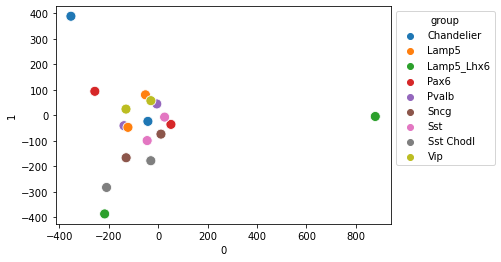

In [3399]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


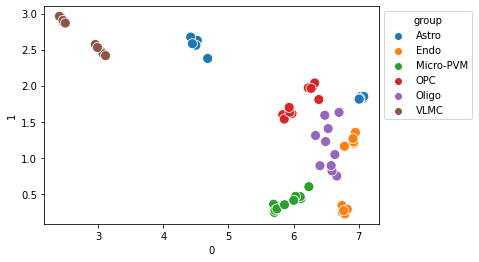

In [3152]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='Non-neuronal']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


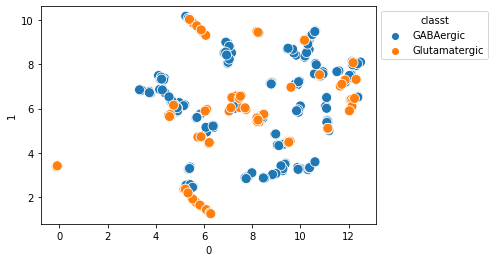

In [2591]:
#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


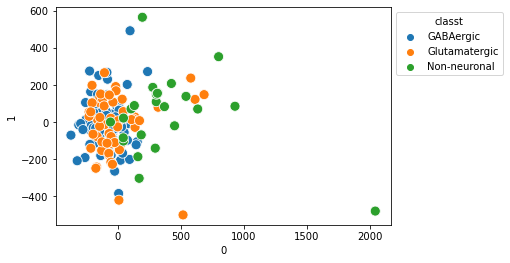

In [2587]:
#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


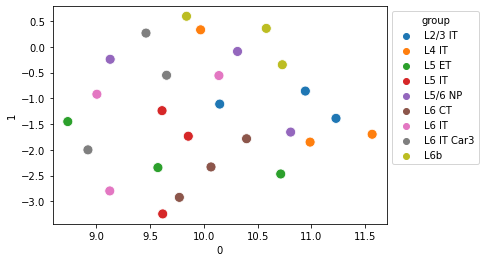

In [2725]:

#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


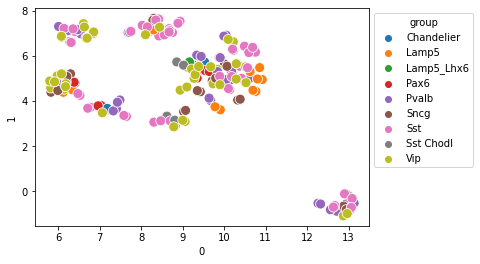

In [2614]:

#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


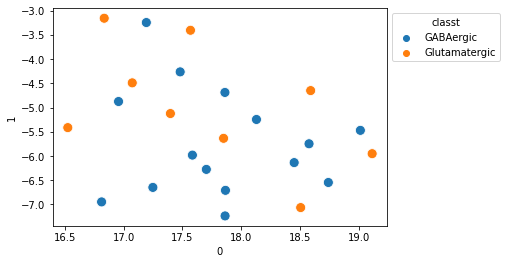

In [2464]:

#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da.head(24)[0], df_proj_2da.head(24)[1],
    hue=df_proj_2da.head(24)['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [2427]:
df_proj_2da

0         1         classt       group
0   8.661607  4.630045      GABAergic  Chandelier
1   9.031061  5.449990      GABAergic       Lamp5
2   6.258849  7.067209      GABAergic  Lamp5_Lhx6
3   8.387507  5.058283      GABAergic        Pax6
4   8.828372  3.945060      GABAergic       Pvalb
5   9.540719  5.439588      GABAergic        Sncg
6   8.815332  5.066208      GABAergic         Sst
7   8.110981  6.083405      GABAergic   Sst Chodl
8   9.524959  3.937522      GABAergic         Vip
9   8.076428  5.445599  Glutamatergic     L2/3 IT
10  9.755854  4.288679  Glutamatergic       L4 IT
11  7.623622  5.164656  Glutamatergic       L5 ET
12  7.609685  7.213424  Glutamatergic       L5 IT
13  9.335237  4.951767  Glutamatergic     L5/6 NP
14  8.091302  6.466461  Glutamatergic       L6 CT
15  5.908108  7.662309  Glutamatergic       L6 IT
16  7.282269  4.547155  Glutamatergic  L6 IT Car3
17  7.996677  3.951995  Glutamatergic         L6b
18  7.214705  7.962621   Non-neuronal       Astro
19  6.781645  7.961120   Non-neuronal        Endo
20  6.308361  7.897794   Non-neuronal   Micro-PVM
21  7.050159  6.974154   Non-neuronal         OPC
22  6.847710  7.751697   Non-neuronal       Oligo
23  6.934944  6.037907   Non-neuronal        VLMC
24  8.678431  4.130846      GABAergic  Chandelier
25  8.425186  3.862102      GABAergic       Lamp5
26  8.852160  6.148104      GABAergic  Lamp5_Lhx6
27  9.249748  4.272975      GABAergic        Pax6
28  9.088362  4.739777      GABAergic       Pvalb
29  8.963717  3.909336      GABAergic        Sncg
30  8.551469  5.904372      GABAergic         Sst
31  7.677602  4.016922      GABAergic   Sst Chodl
32  8.174610  4.362826      GABAergic         Vip
33  7.460493  5.299443  Glutamatergic     L2/3 IT
34  9.402864  4.432516  Glutamatergic       L4 IT
35  6.488868  7.407924  Glutamatergic       L5 ET
36  7.310163  6.881263  Glutamatergic       L5 IT
37  8.888546  5.690189  Glutamatergic     L5/6 NP
38  7.731295  6.973412  Glutamatergic       L6 CT
39  7.035282  7.310637  Glutamatergic       L6 IT
40  8.387115  5.324715  Glutamatergic  L6 IT Car3
41  7.690464  4.789162  Glutamatergic         L6b
42  7.481812  7.601910   Non-neuronal       Astro
43  6.439059  8.149900   Non-neuronal        Endo
44  6.137060  7.678824   Non-neuronal   Micro-PVM
45  6.755466  7.629274   Non-neuronal         OPC
46  6.750287  7.151307   Non-neuronal       Oligo
47  7.851938  4.695174   Non-neuronal        VLMC

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


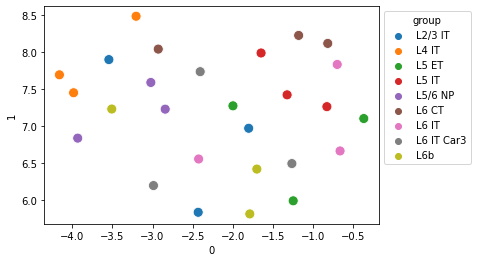

In [2396]:

#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


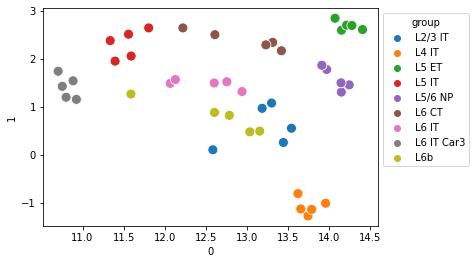

In [2378]:

#df_proj_2da = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2da.tail(45)[0], df_proj_2da.tail(45)[1],
    hue=df_proj_2da.tail(45)['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


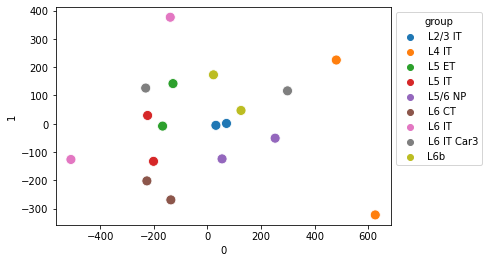

In [1897]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


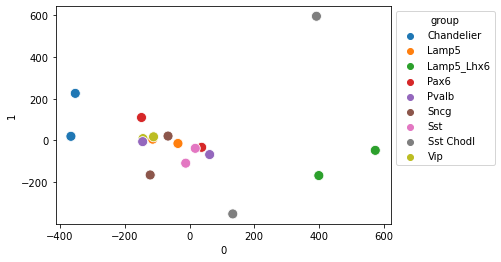

In [1895]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


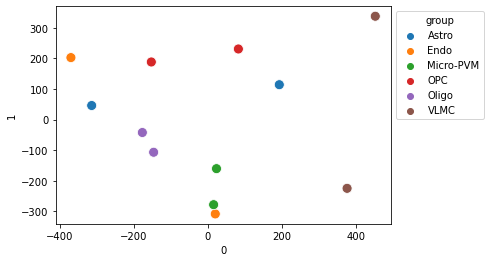

In [1893]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


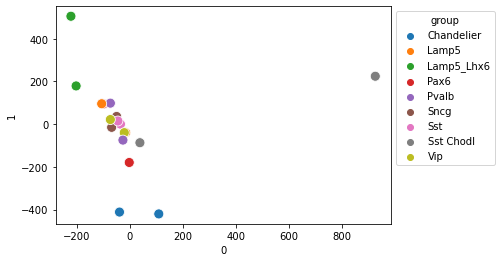

In [1845]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


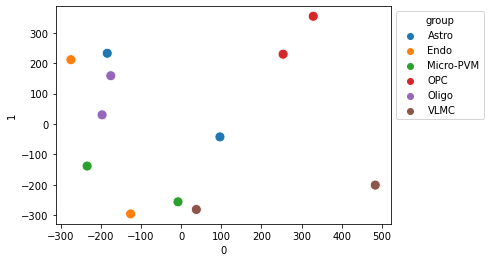

In [1748]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


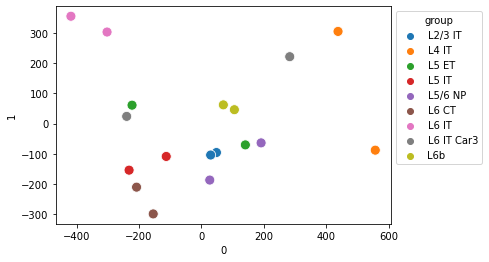

In [1504]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


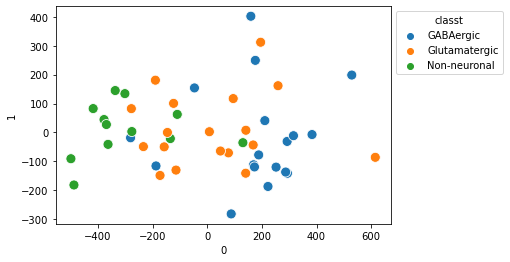

In [1923]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


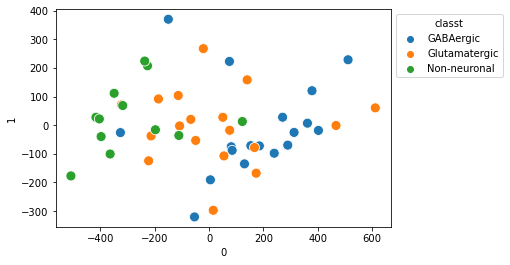

In [1948]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [951]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2da = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


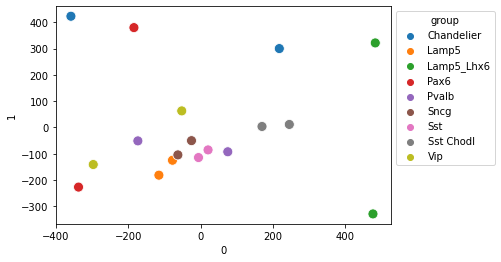

In [1079]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


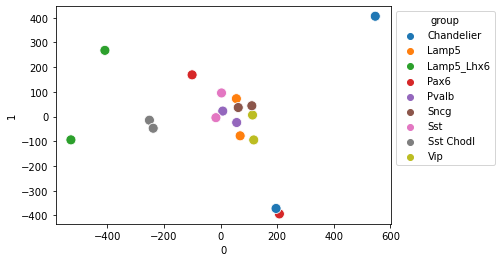

In [1113]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


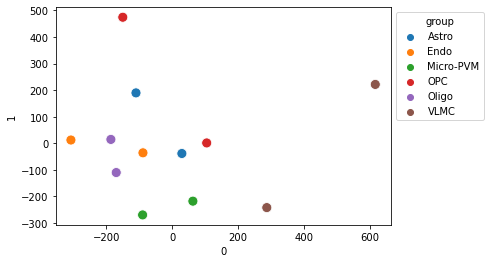

In [1106]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


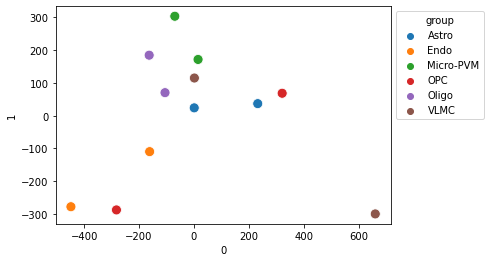

In [1086]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


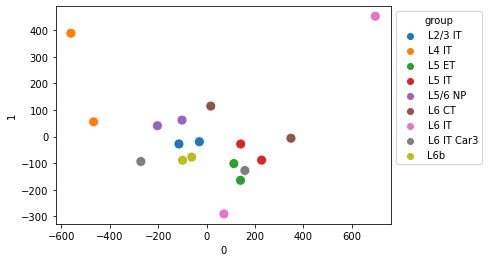

In [1120]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


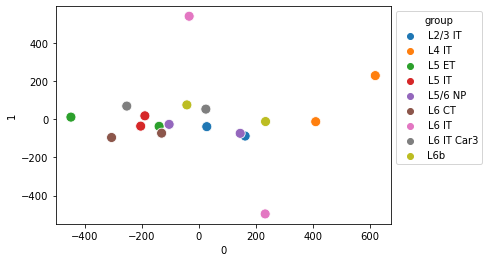

In [1044]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


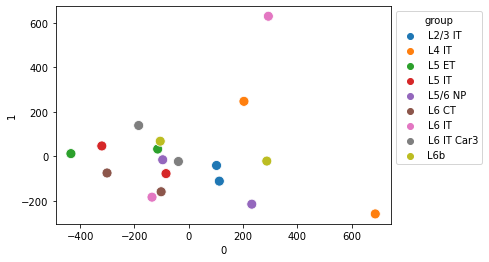

In [1072]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

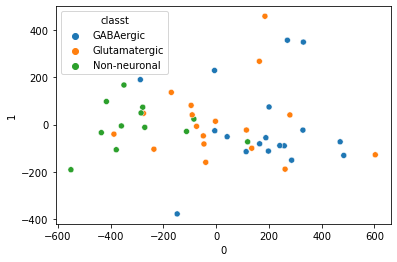

In [1065]:
sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

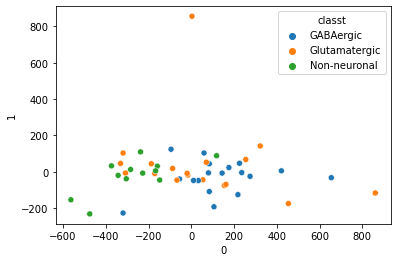

In [686]:
sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

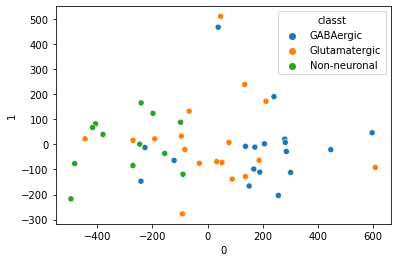

In [615]:

sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

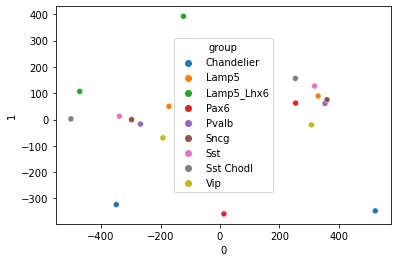

In [484]:

sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

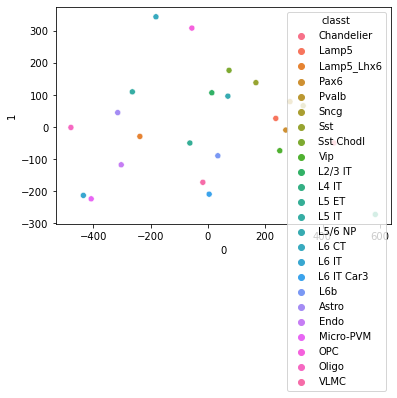

In [128]:
df_proj_2da= pd.DataFrame(proj_2da)

df_proj_2da['classt'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2da[0],df_proj_2da[1],
    hue=df_proj_2da['classt'],
)

In [130]:
dj = pd.concat([df_proj_2d, df_proj_2da])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

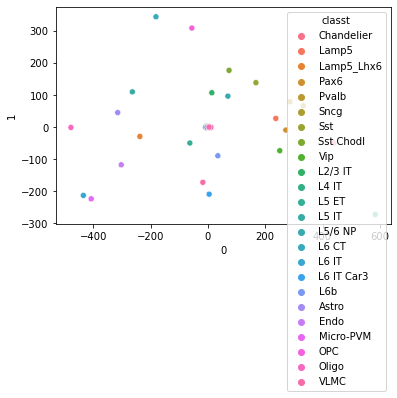

In [131]:

sns.scatterplot(
    dj[0],dj[1],
    hue=dj['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

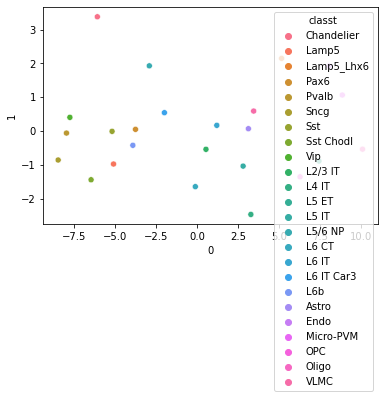

In [126]:
df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

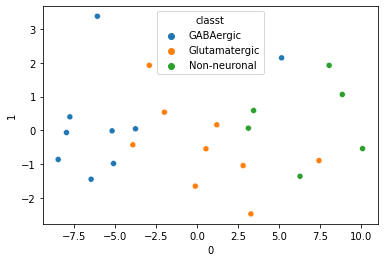

In [105]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

<ipython-input-42-f4eeba2bb161>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


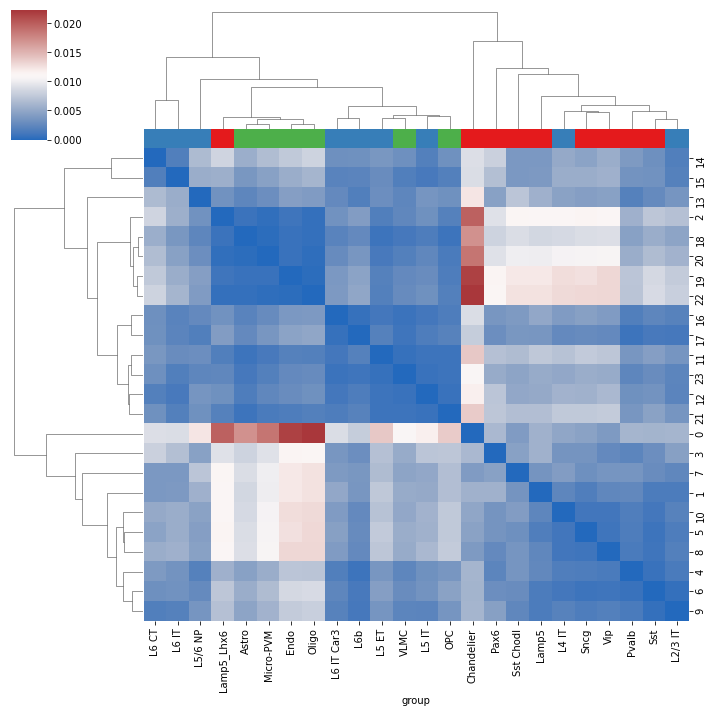

In [42]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-np.round(np.corrcoef(((np.vstack(mean_list)).T)) , 10)
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
mean_list_df = pd.DataFrame(df_dist.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
sns.clustermap(mean_list_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", col_colors=row_colors)

    

<ipython-input-41-7821b6f19fd6>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


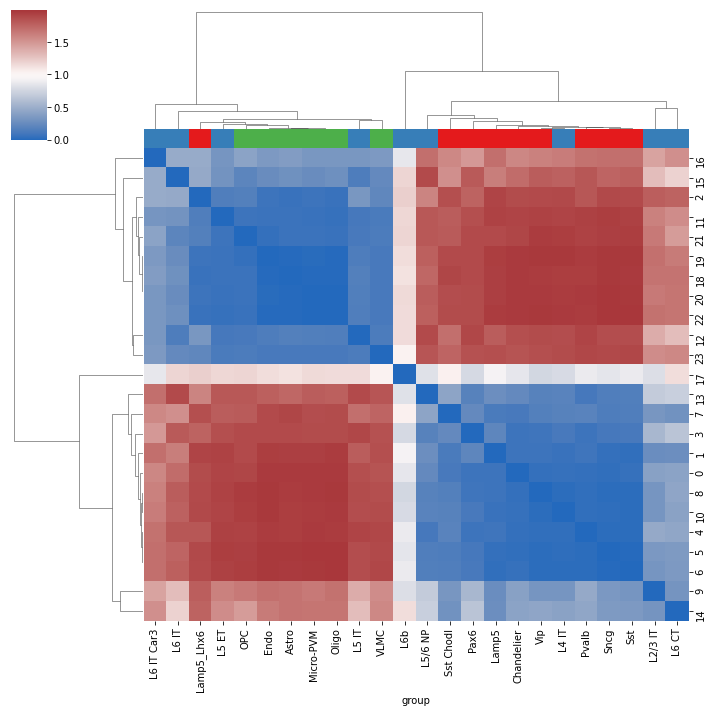

In [41]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(features_sc_df.loc[: , given_bins].mean(axis=1).values.tolist())

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-np.round(np.corrcoef(((np.vstack(mean_list)).T)) , 10)
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
mean_list_df = pd.DataFrame(df_dist.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
sns.clustermap(mean_list_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", col_colors=row_colors)

    

<ipython-input-65-33ff0a366977>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


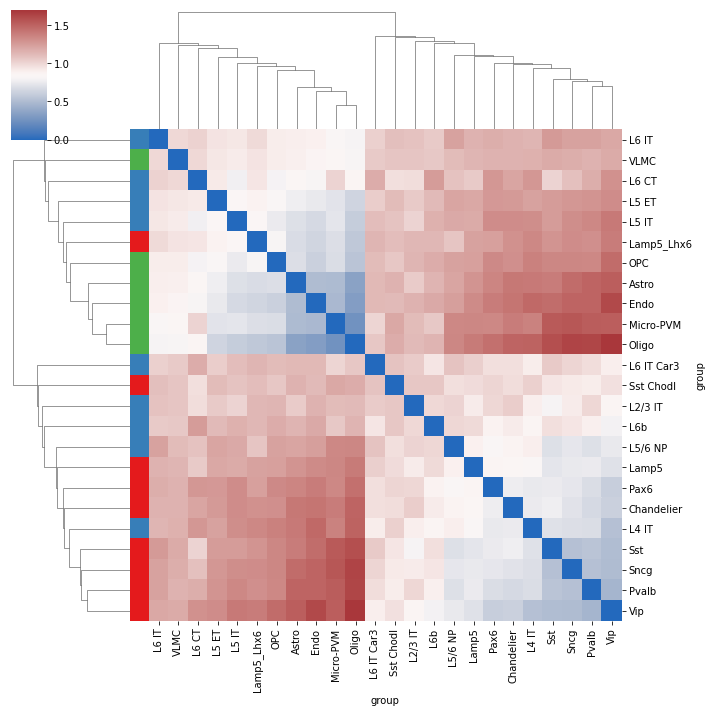

In [65]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [64]:
all_bins_mean.median()

0.05875040218234062

<ipython-input-66-bb885836cf6e>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


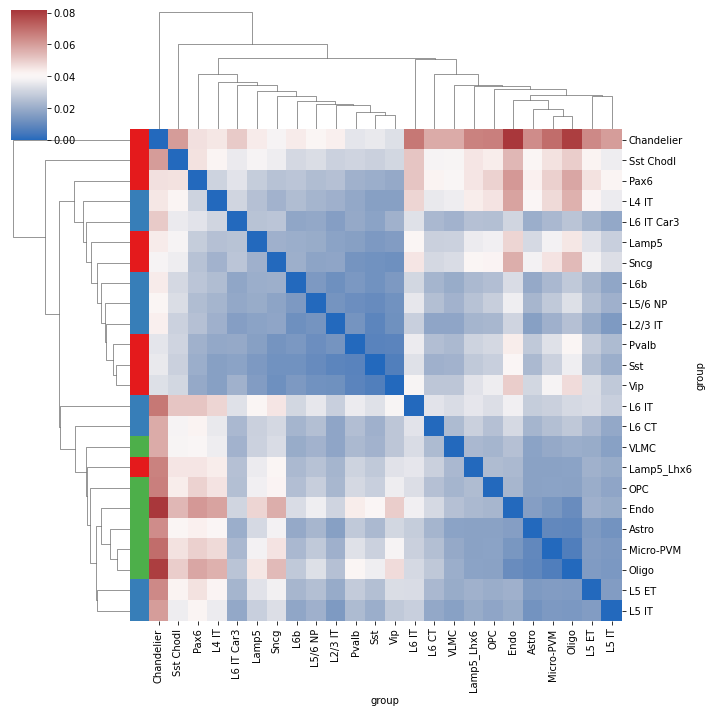

In [66]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


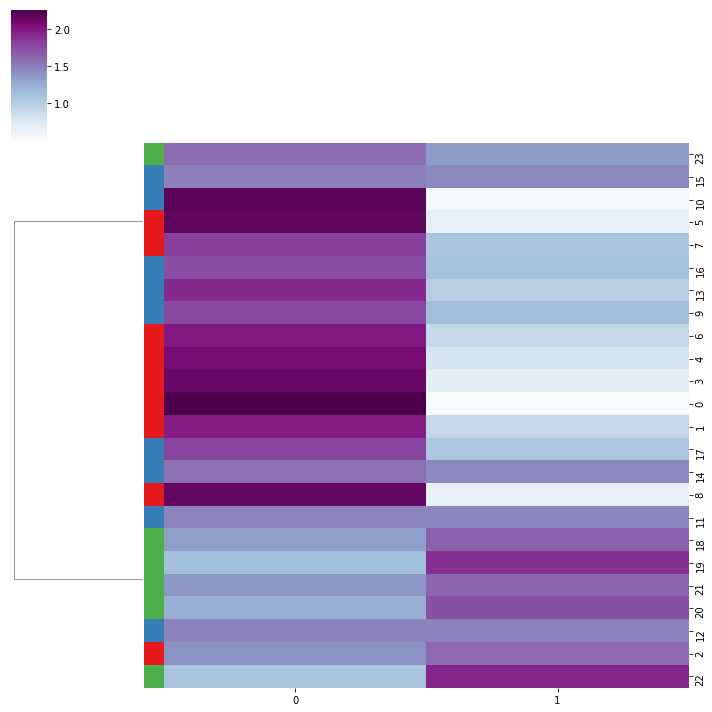

In [57]:
from sklearn.decomposition import NMF



features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
features_sc = abs(features_sc.min()) + features_sc

model = NMF(n_components=2, init='random', random_state=2)
W = model.fit_transform(features_sc)
H = model.components_
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  metric="correlation")



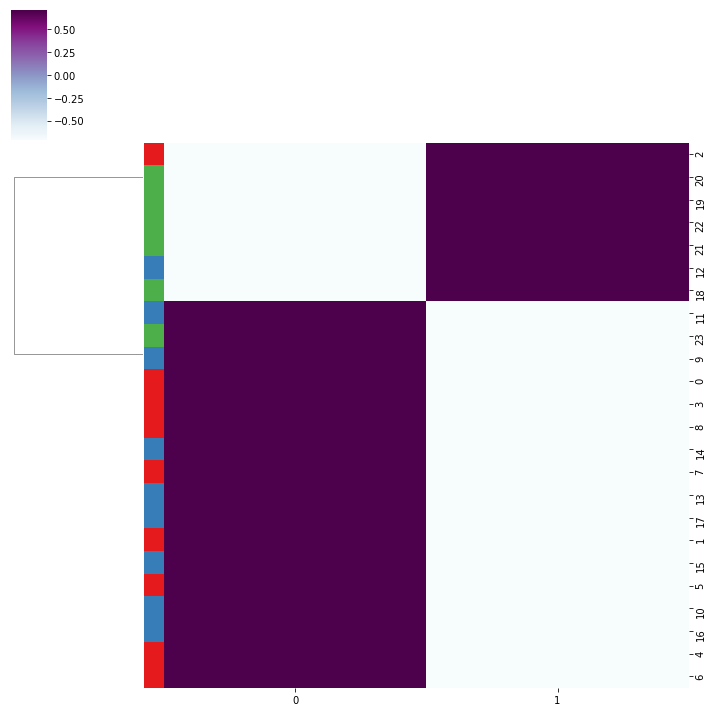

In [61]:
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors, z_score=0)